# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import math
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [6]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Applied Ai/Datasets/Amazon food reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#sorting the final values by time to do  time based splitting

final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [19]:
with open('final.pkl','wb') as f :
    pickle.dump(final,f)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:08<00:00, 2835.64it/s]


In [29]:
#now taking 100000 points 
y=np.array(final["Score"])[:100000]
X=preprocessed_reviews[:100000]


In [30]:
with open('y.pkl','wb') as f :
    pickle.dump(y,f)
with open('preprocessed_reviews.pkl','wb') as f :
    pickle.dump(X,f)


now splitting my data into train test and crossvalidation

In [400]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_1, y_1, test_size=0.3, random_state=0)

In [401]:
with open('y_tr.pkl','wb') as f :
    pickle.dump(y_tr,f)
with open('y_test.pkl','wb') as f :
    pickle.dump(y_test,f)
with open('y_cv.pkl','wb') as f :
    pickle.dump(y_cv,f)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [402]:
#BoW
def BOW(X_tr,X_test,X_cv):
    count_vect = CountVectorizer() #in scikit-learn

    X_tr_BOW=count_vect.fit_transform(X_tr)
    X_cv_BOW=count_vect.transform(X_cv)
    X_test_BOW=count_vect.transform(X_test)
    return  X_tr_BOW, X_test_BOW, X_cv_BOW,count_vect


#final_counts = count_vect.transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])


In [412]:
X_tr_BOW, X_test_BOW, X_cv_BOW,count_vect=BOW(X_tr,X_test,X_cv)

In [413]:
with open('count_vect.pkl','wb') as f :
    pickle.dump(count_vect,f)

In [414]:
with open('X_tr_BOW.pkl','wb') as f :
    pickle.dump(X_tr_BOW,f)
with open('X_test_BOW.pkl','wb') as f :
    pickle.dump(X_test_BOW,f)
with open('X_cv_BOW.pkl','wb') as f :
    pickle.dump(X_cv_BOW,f)

In [415]:
len(count_vect.get_feature_names())

42038

## [4.3] TF-IDF

In [509]:
def tf_idf(X_tr,X_test,X_cv):
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    X_tr_tfidf=tf_idf_vect.fit_transform(X_tr)
    X_cv_tfidf=tf_idf_vect.transform(X_cv)
    X_test_tfidf=tf_idf_vect.transform(X_test)
    return X_tr_tfidf,X_test_tfidf,X_cv_tfidf,tf_idf_vect




In [510]:
 X_tr_tfidf,X_test_tfidf,X_cv_tfidf,tf_idf_vect=tf_idf(X_tr,X_test,X_cv)


In [516]:
with open('X_tr_tfidf.pkl','wb') as f :
    pickle.dump(X_tr_tfidf,f)
with open('X_test_tfidf.pkl','wb') as f :
    pickle.dump(X_test_tfidf,f)
with open('X_cv_tfidf.pkl','wb') as f :
    pickle.dump(X_cv_tfidf,f)
with open('tf_idf_vect.pkl','wb') as f :
    pickle.dump(tf_idf_vect,f)

Converting text into vectors using Avg W2V

## [4.4] Word2Vec

In [527]:
# Train your own Word2Vec model using your own text corpus
def AvgWord2Vec(X_tr,X_test,X_cv):
    sent_of_train=[]
    for sent in X_tr:
        sent_of_train.append(sent.split())

    # List of sentence in X_test text
    sent_of_test=[]
    for sent in X_test:
        sent_of_test.append(sent.split())   

    # List of sentence in X_cv
    sent_of_cv=[]
    for sent in X_cv:
        sent_of_cv.append(sent.split())   

    # # Train your own Word2Vec model using your own train text corpus 
    # # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    print("number of words that occured minimum 5 times ",len(w2v_words))


    train_vectors = []
    for sent in sent_of_train:
        sent_vec = np.zeros(50) 
        cnt_words =0; 
        for word in sent: # 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        train_vectors.append(sent_vec)

    # compute average word2vec for each review for X_test .
    test_vectors = []
    for sent in sent_of_test:
        sent_vec = np.zeros(50) 
        cnt_words =0; 
        for word in sent: # 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_vectors.append(sent_vec)

    # compute average word2vec for each review for X_cv    
    cv_vectors = []
    for sent in sent_of_cv:
        sent_vec = np.zeros(50) 
        cnt_words =0; 
        for word in sent: # 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        cv_vectors.append(sent_vec)
    return  train_vectors,test_vectors,cv_vectors


        
   
   

In [528]:
X_tr_avgw2v,X_test_avgw2v,X_cv_avgw2v=AvgWord2Vec(X_tr,X_test,X_cv)

number of words that occured minimum 5 times  13481


In [529]:
with open('X_tr_avgw2v.pkl','wb') as f :
    pickle.dump(X_tr_avgw2v,f)
with open('X_test_avgw2v.pkl','wb') as f :
    pickle.dump(X_test_avgw2v,f)
with open('X_cv_avgw2v.pkl','wb') as f :
    pickle.dump(X_cv_avgw2v,f)

In [422]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13481
sample words  ['enjoy', 'flavor', 'coffee', 'everyday', 'work', 'alternative', 'chose', 'dark', 'magic', 'also', 'good', 'brew', 'often', 'many', 'flavors', 'tend', 'taste', 'different', 'time', 'usually', 'acidic', 'would', 'care', 'rich', 'order', 'long', 'admit', 'initially', 'wrote', 'review', 'indicated', 'although', 'thought', 'kona', 'not', 'think', 'better', 'favorite', 'peet', 'guess', 'live', 'day', 'two', 'maybe', 'mood', 'first', 'brewed', 'love', 'lovers', 'always']


#### [4.4.1.2] TFIDF weighted W2v

In [423]:
def tfidfW2v(X_tr,X_test,X_cv):
    word2vec_corpus=[]
    for sentence in X_tr:
        word2vec_corpus.append(sentence.split())

    #min_count = 5 considers only those words which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=8)
    word2vec_words = list(word2vec_model.wv.vocab)

    #Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
    tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_tr)

    #This method returns the Average Word2Vec vectors for all reviews in a given dataset
    def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

        #word2vec_corpus will store the list of words for each review.
        word2vec_corpus=[]
        for sentence in dataset:
            word2vec_corpus.append(sentence.split())

        #Use the earlier TF-IDF object to vectorize test and cv data.
        tf_idf_matrix = tf_idf_object.transform(dataset)
        tfidf_features = tf_idf_object.get_feature_names() 

        # We are building a dictionary with words as a key, and the idfs as value
        dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

        #Algorithm for finding the TF-IDF weighted average word2vec vectors.
        tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
        row=0;
        for sentence in tqdm(word2vec_corpus): #For each review/sentence 
            sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
            weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
            for word in sentence: #For each word in a review/sentence
                if((word in word2vec_words) and (word in tfidf_features)):
                    word_vectors = word2vec_model.wv[word]
                    tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                    sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            tfidf_sent_vectors.append(sent_vec)
            row += 1

        tfidf_sent_vectors = np.array(tfidf_sent_vectors)
        return tfidf_sent_vectors

    #Converting the words to word vector representation.
    X_tr_tfidfw2vec = vectorize_tfidf_w2v(X_tr, tf_idf_object, word2vec_model, word2vec_words)
    X_test_tfidfw2vec = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
    X_cv_tfidfw2vec = vectorize_tfidf_w2v(X_cv, tf_idf_object, word2vec_model, word2vec_words)
    return X_tr_tfidfw2vec,X_test_tfidfw2vec,X_cv_tfidfw2vec

#print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_tr_tfidfw2vec.shape)
#print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_tfidfw2vec.shape)
#print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_cv_tfidfw2vec.shape)

In [424]:
X_tr_tfidfw2vec,X_test_tfidfw2vec,X_cv_tfidfw2vec=tfidfW2v(X_tr,X_test,X_cv)





  0%|          | 0/49000 [00:00<?, ?it/s]


  0%|          | 8/49000 [00:00<12:12, 66.84it/s]


  0%|          | 14/49000 [00:00<13:38, 59.86it/s]


  0%|          | 23/49000 [00:00<12:43, 64.17it/s]


  0%|          | 30/49000 [00:00<12:25, 65.68it/s]


  0%|          | 38/49000 [00:00<12:38, 64.59it/s]


  0%|          | 44/49000 [00:00<15:55, 51.25it/s]


  0%|          | 51/49000 [00:00<14:42, 55.50it/s]


  0%|          | 58/49000 [00:00<14:19, 56.91it/s]


  0%|          | 64/49000 [00:01<18:31, 44.01it/s]


  0%|          | 69/49000 [00:01<24:05, 33.84it/s]


  0%|          | 74/49000 [00:01<23:41, 34.41it/s]


  0%|          | 78/49000 [00:01<26:42, 30.52it/s]


  0%|          | 83/49000 [00:01<23:37, 34.51it/s]


  0%|          | 92/49000 [00:01<19:19, 42.18it/s]


  0%|          | 98/49000 [00:02<17:49, 45.70it/s]


  0%|          | 106/49000 [00:02<15:57, 51.07it/s]


  0%|          | 114/49000 [00:02<14:53, 54.73it/s]


  0%|          | 121/49000 [00:02<18:48, 43.31it/s]

  4%|▍         | 1858/49000 [00:40<15:36, 50.34it/s]


  4%|▍         | 1864/49000 [00:40<15:37, 50.28it/s]


  4%|▍         | 1870/49000 [00:41<15:21, 51.13it/s]


  4%|▍         | 1876/49000 [00:41<16:37, 47.24it/s]


  4%|▍         | 1881/49000 [00:41<18:18, 42.89it/s]


  4%|▍         | 1886/49000 [00:41<20:40, 37.97it/s]


  4%|▍         | 1891/49000 [00:41<19:41, 39.88it/s]


  4%|▍         | 1896/49000 [00:41<18:37, 42.17it/s]


  4%|▍         | 1904/49000 [00:41<17:00, 46.13it/s]


  4%|▍         | 1911/49000 [00:41<15:31, 50.53it/s]


  4%|▍         | 1920/49000 [00:42<14:04, 55.74it/s]


  4%|▍         | 1929/49000 [00:42<12:48, 61.29it/s]


  4%|▍         | 1936/49000 [00:42<14:31, 54.00it/s]


  4%|▍         | 1943/49000 [00:42<13:32, 57.89it/s]


  4%|▍         | 1950/49000 [00:42<13:48, 56.80it/s]


  4%|▍         | 1959/49000 [00:42<12:22, 63.37it/s]


  4%|▍         | 1966/49000 [00:42<16:03, 48.80it/s]


  4%|▍         | 1974/49000 [00:43<15:22, 50.97it/s]


  4%|▍    

  6%|▌         | 2806/49000 [01:01<27:52, 27.61it/s]


  6%|▌         | 2810/49000 [01:01<26:28, 29.07it/s]


  6%|▌         | 2814/49000 [01:01<31:43, 24.26it/s]


  6%|▌         | 2821/49000 [01:01<25:41, 29.96it/s]


  6%|▌         | 2827/49000 [01:01<23:00, 33.45it/s]


  6%|▌         | 2833/49000 [01:02<21:03, 36.55it/s]


  6%|▌         | 2838/49000 [01:02<21:32, 35.70it/s]


  6%|▌         | 2843/49000 [01:02<20:50, 36.92it/s]


  6%|▌         | 2848/49000 [01:02<25:43, 29.90it/s]


  6%|▌         | 2852/49000 [01:02<27:40, 27.80it/s]


  6%|▌         | 2856/49000 [01:02<27:59, 27.47it/s]


  6%|▌         | 2860/49000 [01:03<27:14, 28.22it/s]


  6%|▌         | 2864/49000 [01:03<26:19, 29.22it/s]


  6%|▌         | 2868/49000 [01:03<34:10, 22.50it/s]


  6%|▌         | 2874/49000 [01:03<28:24, 27.06it/s]


  6%|▌         | 2878/49000 [01:03<26:53, 28.58it/s]


  6%|▌         | 2885/49000 [01:03<22:51, 33.61it/s]


  6%|▌         | 2890/49000 [01:03<21:06, 36.41it/s]


  6%|▌    

  8%|▊         | 3788/49000 [01:21<13:05, 57.55it/s]


  8%|▊         | 3795/49000 [01:21<13:30, 55.76it/s]


  8%|▊         | 3802/49000 [01:21<13:09, 57.24it/s]


  8%|▊         | 3809/49000 [01:21<13:44, 54.78it/s]


  8%|▊         | 3818/49000 [01:22<12:09, 61.97it/s]


  8%|▊         | 3826/49000 [01:22<11:20, 66.34it/s]


  8%|▊         | 3834/49000 [01:22<14:04, 53.46it/s]


  8%|▊         | 3841/49000 [01:22<15:34, 48.31it/s]


  8%|▊         | 3848/49000 [01:22<16:45, 44.91it/s]


  8%|▊         | 3853/49000 [01:22<18:01, 41.73it/s]


  8%|▊         | 3858/49000 [01:23<20:32, 36.62it/s]


  8%|▊         | 3863/49000 [01:23<27:20, 27.51it/s]


  8%|▊         | 3867/49000 [01:23<24:56, 30.17it/s]


  8%|▊         | 3874/49000 [01:23<22:51, 32.91it/s]


  8%|▊         | 3878/49000 [01:23<23:48, 31.58it/s]


  8%|▊         | 3882/49000 [01:23<25:36, 29.36it/s]


  8%|▊         | 3887/49000 [01:24<22:41, 33.13it/s]


  8%|▊         | 3893/49000 [01:24<20:27, 36.75it/s]


  8%|▊    

 10%|▉         | 4781/49000 [01:41<14:40, 50.21it/s]


 10%|▉         | 4787/49000 [01:41<14:34, 50.56it/s]


 10%|▉         | 4793/49000 [01:41<13:59, 52.69it/s]


 10%|▉         | 4799/49000 [01:42<14:49, 49.71it/s]


 10%|▉         | 4805/49000 [01:42<14:51, 49.59it/s]


 10%|▉         | 4812/49000 [01:42<13:53, 53.02it/s]


 10%|▉         | 4824/49000 [01:42<11:35, 63.51it/s]


 10%|▉         | 4832/49000 [01:42<13:52, 53.08it/s]


 10%|▉         | 4839/49000 [01:42<12:56, 56.85it/s]


 10%|▉         | 4846/49000 [01:42<13:24, 54.91it/s]


 10%|▉         | 4856/49000 [01:42<11:37, 63.30it/s]


 10%|▉         | 4864/49000 [01:43<14:19, 51.35it/s]


 10%|▉         | 4871/49000 [01:43<14:40, 50.10it/s]


 10%|▉         | 4879/49000 [01:43<13:21, 55.07it/s]


 10%|▉         | 4886/49000 [01:43<21:55, 33.55it/s]


 10%|▉         | 4891/49000 [01:43<23:34, 31.19it/s]


 10%|▉         | 4898/49000 [01:44<20:04, 36.61it/s]


 10%|█         | 4903/49000 [01:44<18:53, 38.91it/s]


 10%|█    

 12%|█▏        | 5827/49000 [02:01<12:46, 56.36it/s]


 12%|█▏        | 5834/49000 [02:01<12:19, 58.36it/s]


 12%|█▏        | 5841/49000 [02:02<12:37, 56.97it/s]


 12%|█▏        | 5848/49000 [02:02<14:38, 49.11it/s]


 12%|█▏        | 5857/49000 [02:02<12:41, 56.67it/s]


 12%|█▏        | 5864/49000 [02:02<12:50, 55.97it/s]


 12%|█▏        | 5871/49000 [02:02<13:17, 54.08it/s]


 12%|█▏        | 5882/49000 [02:02<11:28, 62.65it/s]


 12%|█▏        | 5892/49000 [02:02<10:15, 70.02it/s]


 12%|█▏        | 5900/49000 [02:03<10:05, 71.24it/s]


 12%|█▏        | 5908/49000 [02:03<10:44, 66.89it/s]


 12%|█▏        | 5916/49000 [02:03<11:29, 62.50it/s]


 12%|█▏        | 5923/49000 [02:03<12:09, 59.08it/s]


 12%|█▏        | 5934/49000 [02:03<11:13, 63.98it/s]


 12%|█▏        | 5941/49000 [02:03<11:15, 63.75it/s]


 12%|█▏        | 5948/49000 [02:03<16:51, 42.54it/s]


 12%|█▏        | 5957/49000 [02:04<14:29, 49.48it/s]


 12%|█▏        | 5964/49000 [02:04<13:51, 51.76it/s]


 12%|█▏   

 14%|█▍        | 6914/49000 [02:22<17:15, 40.65it/s]


 14%|█▍        | 6919/49000 [02:22<16:46, 41.81it/s]


 14%|█▍        | 6926/49000 [02:22<14:56, 46.91it/s]


 14%|█▍        | 6932/49000 [02:22<14:58, 46.83it/s]


 14%|█▍        | 6937/49000 [02:22<19:34, 35.80it/s]


 14%|█▍        | 6944/49000 [02:22<16:51, 41.60it/s]


 14%|█▍        | 6950/49000 [02:22<15:50, 44.22it/s]


 14%|█▍        | 6956/49000 [02:23<15:31, 45.12it/s]


 14%|█▍        | 6961/49000 [02:23<16:16, 43.04it/s]


 14%|█▍        | 6967/49000 [02:23<15:10, 46.19it/s]


 14%|█▍        | 6972/49000 [02:23<17:04, 41.03it/s]


 14%|█▍        | 6977/49000 [02:23<16:41, 41.98it/s]


 14%|█▍        | 6982/49000 [02:23<16:49, 41.61it/s]


 14%|█▍        | 6992/49000 [02:23<14:20, 48.84it/s]


 14%|█▍        | 6998/49000 [02:24<14:38, 47.81it/s]


 14%|█▍        | 7004/49000 [02:24<13:48, 50.69it/s]


 14%|█▍        | 7016/49000 [02:24<11:31, 60.69it/s]


 14%|█▍        | 7024/49000 [02:24<14:03, 49.76it/s]


 14%|█▍   

 16%|█▌        | 7928/49000 [02:42<18:01, 37.97it/s]


 16%|█▌        | 7933/49000 [02:42<17:31, 39.04it/s]


 16%|█▌        | 7938/49000 [02:42<18:27, 37.09it/s]


 16%|█▌        | 7947/49000 [02:42<15:38, 43.73it/s]


 16%|█▌        | 7953/49000 [02:42<15:12, 44.97it/s]


 16%|█▌        | 7958/49000 [02:42<16:00, 42.73it/s]


 16%|█▋        | 7966/49000 [02:42<14:11, 48.17it/s]


 16%|█▋        | 7974/49000 [02:43<12:31, 54.62it/s]


 16%|█▋        | 7981/49000 [02:43<12:28, 54.81it/s]


 16%|█▋        | 7992/49000 [02:43<11:04, 61.74it/s]


 16%|█▋        | 7999/49000 [02:43<11:40, 58.56it/s]


 16%|█▋        | 8006/49000 [02:43<11:56, 57.20it/s]


 16%|█▋        | 8013/49000 [02:43<11:27, 59.63it/s]


 16%|█▋        | 8020/49000 [02:43<11:57, 57.12it/s]


 16%|█▋        | 8028/49000 [02:43<11:21, 60.13it/s]


 16%|█▋        | 8035/49000 [02:44<11:46, 58.00it/s]


 16%|█▋        | 8041/49000 [02:44<14:50, 45.99it/s]


 16%|█▋        | 8047/49000 [02:44<13:51, 49.24it/s]


 16%|█▋   

 18%|█▊        | 8993/49000 [03:02<10:58, 60.78it/s]


 18%|█▊        | 9000/49000 [03:02<11:57, 55.79it/s]


 18%|█▊        | 9006/49000 [03:02<13:23, 49.78it/s]


 18%|█▊        | 9014/49000 [03:02<13:20, 49.98it/s]


 18%|█▊        | 9020/49000 [03:02<13:11, 50.53it/s]


 18%|█▊        | 9026/49000 [03:02<15:10, 43.90it/s]


 18%|█▊        | 9031/49000 [03:03<18:14, 36.53it/s]


 18%|█▊        | 9037/49000 [03:03<16:23, 40.65it/s]


 18%|█▊        | 9042/49000 [03:03<17:00, 39.16it/s]


 18%|█▊        | 9047/49000 [03:03<17:07, 38.89it/s]


 18%|█▊        | 9052/49000 [03:03<19:28, 34.19it/s]


 18%|█▊        | 9059/49000 [03:03<16:31, 40.27it/s]


 18%|█▊        | 9065/49000 [03:03<15:11, 43.82it/s]


 19%|█▊        | 9077/49000 [03:03<12:24, 53.64it/s]


 19%|█▊        | 9084/49000 [03:04<11:38, 57.16it/s]


 19%|█▊        | 9091/49000 [03:04<11:23, 58.41it/s]


 19%|█▊        | 9098/49000 [03:04<12:25, 53.50it/s]


 19%|█▊        | 9107/49000 [03:04<11:09, 59.61it/s]


 19%|█▊   

 23%|██▎       | 11066/49000 [03:43<16:33, 38.20it/s]


 23%|██▎       | 11071/49000 [03:43<20:44, 30.48it/s]


 23%|██▎       | 11078/49000 [03:43<18:33, 34.04it/s]


 23%|██▎       | 11086/49000 [03:43<15:45, 40.10it/s]


 23%|██▎       | 11095/49000 [03:43<13:21, 47.29it/s]


 23%|██▎       | 11106/49000 [03:43<11:10, 56.54it/s]


 23%|██▎       | 11114/49000 [03:43<11:21, 55.58it/s]


 23%|██▎       | 11123/49000 [03:44<10:35, 59.59it/s]


 23%|██▎       | 11132/49000 [03:44<09:37, 65.63it/s]


 23%|██▎       | 11140/49000 [03:44<09:06, 69.24it/s]


 23%|██▎       | 11148/49000 [03:44<09:21, 67.46it/s]


 23%|██▎       | 11156/49000 [03:44<11:56, 52.79it/s]


 23%|██▎       | 11163/49000 [03:44<13:19, 47.34it/s]


 23%|██▎       | 11169/49000 [03:44<13:54, 45.32it/s]


 23%|██▎       | 11175/49000 [03:45<14:38, 43.06it/s]


 23%|██▎       | 11180/49000 [03:45<19:06, 32.98it/s]


 23%|██▎       | 11184/49000 [03:45<23:36, 26.70it/s]


 23%|██▎       | 11188/49000 [03:45<22:07, 28.47

 27%|██▋       | 13074/49000 [04:22<21:37, 27.69it/s]


 27%|██▋       | 13083/49000 [04:22<17:16, 34.64it/s]


 27%|██▋       | 13089/49000 [04:23<15:56, 37.54it/s]


 27%|██▋       | 13097/49000 [04:23<13:53, 43.08it/s]


 27%|██▋       | 13103/49000 [04:23<13:03, 45.80it/s]


 27%|██▋       | 13109/49000 [04:23<12:39, 47.24it/s]


 27%|██▋       | 13120/49000 [04:23<10:38, 56.15it/s]


 27%|██▋       | 13129/49000 [04:23<09:29, 62.93it/s]


 27%|██▋       | 13137/49000 [04:23<08:54, 67.10it/s]


 27%|██▋       | 13145/49000 [04:23<09:00, 66.37it/s]


 27%|██▋       | 13153/49000 [04:24<10:43, 55.70it/s]


 27%|██▋       | 13160/49000 [04:24<10:28, 57.06it/s]


 27%|██▋       | 13167/49000 [04:24<11:52, 50.31it/s]


 27%|██▋       | 13174/49000 [04:24<10:53, 54.85it/s]


 27%|██▋       | 13180/49000 [04:24<11:36, 51.43it/s]


 27%|██▋       | 13186/49000 [04:24<11:48, 50.53it/s]


 27%|██▋       | 13192/49000 [04:24<11:37, 51.31it/s]


 27%|██▋       | 13198/49000 [04:24<11:46, 50.69

 31%|███       | 15007/49000 [05:02<12:25, 45.57it/s]


 31%|███       | 15012/49000 [05:02<13:59, 40.49it/s]


 31%|███       | 15017/49000 [05:03<14:58, 37.82it/s]


 31%|███       | 15021/49000 [05:03<19:02, 29.74it/s]


 31%|███       | 15027/49000 [05:03<16:36, 34.11it/s]


 31%|███       | 15032/49000 [05:03<15:12, 37.22it/s]


 31%|███       | 15043/49000 [05:03<12:13, 46.28it/s]


 31%|███       | 15050/49000 [05:03<11:01, 51.32it/s]


 31%|███       | 15057/49000 [05:03<12:17, 46.04it/s]


 31%|███       | 15063/49000 [05:04<13:20, 42.41it/s]


 31%|███       | 15068/49000 [05:04<13:07, 43.09it/s]


 31%|███       | 15073/49000 [05:04<15:57, 35.44it/s]


 31%|███       | 15078/49000 [05:04<15:11, 37.21it/s]


 31%|███       | 15085/49000 [05:04<13:04, 43.24it/s]


 31%|███       | 15090/49000 [05:04<21:17, 26.55it/s]


 31%|███       | 15095/49000 [05:05<18:21, 30.79it/s]


 31%|███       | 15100/49000 [05:05<18:25, 30.67it/s]


 31%|███       | 15107/49000 [05:05<15:37, 36.16

 35%|███▍      | 17041/49000 [05:43<09:36, 55.47it/s]


 35%|███▍      | 17048/49000 [05:43<09:29, 56.07it/s]


 35%|███▍      | 17055/49000 [05:43<09:14, 57.62it/s]


 35%|███▍      | 17062/49000 [05:43<09:09, 58.16it/s]


 35%|███▍      | 17069/49000 [05:43<09:01, 59.00it/s]


 35%|███▍      | 17077/49000 [05:43<08:24, 63.32it/s]


 35%|███▍      | 17084/49000 [05:43<08:53, 59.83it/s]


 35%|███▍      | 17092/49000 [05:43<08:22, 63.53it/s]


 35%|███▍      | 17099/49000 [05:44<08:24, 63.27it/s]


 35%|███▍      | 17109/49000 [05:44<07:50, 67.83it/s]


 35%|███▍      | 17116/49000 [05:44<07:57, 66.74it/s]


 35%|███▍      | 17123/49000 [05:44<07:57, 66.77it/s]


 35%|███▍      | 17130/49000 [05:44<09:13, 57.59it/s]


 35%|███▍      | 17137/49000 [05:44<09:31, 55.78it/s]


 35%|███▍      | 17143/49000 [05:44<10:01, 52.97it/s]


 35%|███▌      | 17153/49000 [05:44<08:40, 61.13it/s]


 35%|███▌      | 17163/49000 [05:44<07:42, 68.82it/s]


 35%|███▌      | 17171/49000 [05:45<08:03, 65.85

 39%|███▉      | 19085/49000 [06:22<13:17, 37.49it/s]


 39%|███▉      | 19090/49000 [06:22<14:17, 34.88it/s]


 39%|███▉      | 19096/49000 [06:23<12:38, 39.44it/s]


 39%|███▉      | 19103/49000 [06:23<11:02, 45.15it/s]


 39%|███▉      | 19109/49000 [06:23<10:13, 48.69it/s]


 39%|███▉      | 19115/49000 [06:23<19:09, 26.00it/s]


 39%|███▉      | 19122/49000 [06:23<16:25, 30.31it/s]


 39%|███▉      | 19127/49000 [06:24<15:36, 31.89it/s]


 39%|███▉      | 19132/49000 [06:24<15:39, 31.78it/s]


 39%|███▉      | 19138/49000 [06:24<13:34, 36.68it/s]


 39%|███▉      | 19146/49000 [06:24<11:43, 42.43it/s]


 39%|███▉      | 19152/49000 [06:24<11:09, 44.58it/s]


 39%|███▉      | 19158/49000 [06:24<11:42, 42.49it/s]


 39%|███▉      | 19163/49000 [06:24<11:38, 42.71it/s]


 39%|███▉      | 19171/49000 [06:24<10:02, 49.49it/s]


 39%|███▉      | 19177/49000 [06:25<10:19, 48.13it/s]


 39%|███▉      | 19183/49000 [06:25<10:13, 48.60it/s]


 39%|███▉      | 19189/49000 [06:25<10:40, 46.55

 43%|████▎     | 21220/49000 [07:01<09:49, 47.10it/s]


 43%|████▎     | 21227/49000 [07:01<09:04, 51.00it/s]


 43%|████▎     | 21233/49000 [07:02<09:18, 49.74it/s]


 43%|████▎     | 21239/49000 [07:02<08:51, 52.19it/s]


 43%|████▎     | 21246/49000 [07:02<08:21, 55.34it/s]


 43%|████▎     | 21252/49000 [07:02<09:21, 49.43it/s]


 43%|████▎     | 21258/49000 [07:02<08:55, 51.82it/s]


 43%|████▎     | 21265/49000 [07:02<08:22, 55.17it/s]


 43%|████▎     | 21275/49000 [07:02<07:18, 63.17it/s]


 43%|████▎     | 21282/49000 [07:02<09:54, 46.59it/s]


 43%|████▎     | 21288/49000 [07:03<10:04, 45.86it/s]


 43%|████▎     | 21297/49000 [07:03<09:00, 51.23it/s]


 43%|████▎     | 21304/49000 [07:03<08:39, 53.33it/s]


 43%|████▎     | 21310/49000 [07:03<09:05, 50.74it/s]


 44%|████▎     | 21318/49000 [07:03<08:07, 56.79it/s]


 44%|████▎     | 21326/49000 [07:03<07:44, 59.60it/s]


 44%|████▎     | 21333/49000 [07:03<08:34, 53.81it/s]


 44%|████▎     | 21345/49000 [07:03<07:10, 64.30

 47%|████▋     | 23249/49000 [07:41<06:27, 66.43it/s]


 47%|████▋     | 23257/49000 [07:41<07:28, 57.41it/s]


 47%|████▋     | 23265/49000 [07:41<06:54, 62.03it/s]


 47%|████▋     | 23274/49000 [07:41<06:50, 62.61it/s]


 48%|████▊     | 23281/49000 [07:41<07:04, 60.52it/s]


 48%|████▊     | 23290/49000 [07:41<06:31, 65.69it/s]


 48%|████▊     | 23297/49000 [07:41<06:55, 61.85it/s]


 48%|████▊     | 23304/49000 [07:42<06:45, 63.44it/s]


 48%|████▊     | 23314/49000 [07:42<06:21, 67.27it/s]


 48%|████▊     | 23322/49000 [07:42<06:05, 70.32it/s]


 48%|████▊     | 23330/49000 [07:42<06:07, 69.78it/s]


 48%|████▊     | 23338/49000 [07:42<09:41, 44.10it/s]


 48%|████▊     | 23344/49000 [07:42<12:19, 34.68it/s]


 48%|████▊     | 23349/49000 [07:43<12:40, 33.74it/s]


 48%|████▊     | 23354/49000 [07:43<13:25, 31.85it/s]


 48%|████▊     | 23358/49000 [07:43<13:02, 32.78it/s]


 48%|████▊     | 23365/49000 [07:43<11:10, 38.25it/s]


 48%|████▊     | 23374/49000 [07:43<09:15, 46.10

 52%|█████▏    | 25249/49000 [08:20<09:39, 40.97it/s]


 52%|█████▏    | 25254/49000 [08:20<09:24, 42.06it/s]


 52%|█████▏    | 25259/49000 [08:21<09:34, 41.35it/s]


 52%|█████▏    | 25264/49000 [08:21<09:33, 41.38it/s]


 52%|█████▏    | 25269/49000 [08:21<09:40, 40.87it/s]


 52%|█████▏    | 25275/49000 [08:21<09:02, 43.75it/s]


 52%|█████▏    | 25280/49000 [08:21<09:11, 43.03it/s]


 52%|█████▏    | 25289/49000 [08:21<07:45, 50.98it/s]


 52%|█████▏    | 25295/49000 [08:21<08:23, 47.04it/s]


 52%|█████▏    | 25301/49000 [08:21<07:57, 49.58it/s]


 52%|█████▏    | 25309/49000 [08:21<07:13, 54.63it/s]


 52%|█████▏    | 25319/49000 [08:22<06:15, 63.14it/s]


 52%|█████▏    | 25327/49000 [08:22<06:19, 62.42it/s]


 52%|█████▏    | 25334/49000 [08:22<06:45, 58.43it/s]


 52%|█████▏    | 25342/49000 [08:22<06:38, 59.39it/s]


 52%|█████▏    | 25349/49000 [08:22<06:29, 60.65it/s]


 52%|█████▏    | 25356/49000 [08:22<06:32, 60.30it/s]


 52%|█████▏    | 25364/49000 [08:22<06:39, 59.23

 55%|█████▌    | 27161/49000 [08:59<07:08, 50.96it/s]


 55%|█████▌    | 27167/49000 [09:00<06:50, 53.13it/s]


 55%|█████▌    | 27173/49000 [09:00<06:45, 53.87it/s]


 55%|█████▌    | 27179/49000 [09:00<07:15, 50.06it/s]


 55%|█████▌    | 27185/49000 [09:00<08:00, 45.44it/s]


 55%|█████▌    | 27190/49000 [09:00<08:07, 44.74it/s]


 56%|█████▌    | 27196/49000 [09:00<07:30, 48.35it/s]


 56%|█████▌    | 27202/49000 [09:00<07:09, 50.73it/s]


 56%|█████▌    | 27211/49000 [09:00<06:27, 56.22it/s]


 56%|█████▌    | 27219/49000 [09:00<05:53, 61.61it/s]


 56%|█████▌    | 27226/49000 [09:01<05:45, 63.10it/s]


 56%|█████▌    | 27233/49000 [09:01<07:08, 50.80it/s]


 56%|█████▌    | 27239/49000 [09:01<06:58, 52.04it/s]


 56%|█████▌    | 27245/49000 [09:01<08:23, 43.24it/s]


 56%|█████▌    | 27252/49000 [09:01<07:40, 47.20it/s]


 56%|█████▌    | 27262/49000 [09:01<06:32, 55.36it/s]


 56%|█████▌    | 27269/49000 [09:02<08:21, 43.34it/s]


 56%|█████▌    | 27275/49000 [09:02<09:45, 37.08

 60%|█████▉    | 29216/49000 [09:39<05:48, 56.75it/s]


 60%|█████▉    | 29223/49000 [09:40<05:54, 55.76it/s]


 60%|█████▉    | 29229/49000 [09:40<05:47, 56.92it/s]


 60%|█████▉    | 29237/49000 [09:40<05:21, 61.49it/s]


 60%|█████▉    | 29247/49000 [09:40<04:46, 68.85it/s]


 60%|█████▉    | 29255/49000 [09:40<04:43, 69.66it/s]


 60%|█████▉    | 29265/49000 [09:40<04:22, 75.13it/s]


 60%|█████▉    | 29273/49000 [09:40<04:47, 68.71it/s]


 60%|█████▉    | 29281/49000 [09:40<05:02, 65.15it/s]


 60%|█████▉    | 29288/49000 [09:41<06:07, 53.68it/s]


 60%|█████▉    | 29297/49000 [09:41<05:30, 59.65it/s]


 60%|█████▉    | 29305/49000 [09:41<05:06, 64.31it/s]


 60%|█████▉    | 29312/49000 [09:41<05:57, 55.09it/s]


 60%|█████▉    | 29319/49000 [09:41<08:08, 40.32it/s]


 60%|█████▉    | 29325/49000 [09:42<10:25, 31.44it/s]


 60%|█████▉    | 29330/49000 [09:42<09:43, 33.69it/s]


 60%|█████▉    | 29335/49000 [09:42<09:01, 36.31it/s]


 60%|█████▉    | 29340/49000 [09:42<08:43, 37.54

 64%|██████▎   | 31227/49000 [10:19<05:38, 52.55it/s]


 64%|██████▎   | 31233/49000 [10:19<06:53, 42.93it/s]


 64%|██████▍   | 31239/49000 [10:19<06:29, 45.57it/s]


 64%|██████▍   | 31245/49000 [10:20<07:34, 39.09it/s]


 64%|██████▍   | 31250/49000 [10:20<07:50, 37.70it/s]


 64%|██████▍   | 31256/49000 [10:20<07:01, 42.10it/s]


 64%|██████▍   | 31262/49000 [10:20<06:43, 43.94it/s]


 64%|██████▍   | 31269/49000 [10:20<06:28, 45.63it/s]


 64%|██████▍   | 31274/49000 [10:20<06:43, 43.94it/s]


 64%|██████▍   | 31279/49000 [10:20<08:13, 35.92it/s]


 64%|██████▍   | 31285/49000 [10:21<07:52, 37.49it/s]


 64%|██████▍   | 31290/49000 [10:21<08:18, 35.56it/s]


 64%|██████▍   | 31294/49000 [10:21<08:11, 36.01it/s]


 64%|██████▍   | 31298/49000 [10:21<08:13, 35.86it/s]


 64%|██████▍   | 31302/49000 [10:21<08:17, 35.56it/s]


 64%|██████▍   | 31308/49000 [10:21<07:17, 40.45it/s]


 64%|██████▍   | 31314/49000 [10:21<06:38, 44.36it/s]


 64%|██████▍   | 31319/49000 [10:21<06:42, 43.90

 68%|██████▊   | 33187/49000 [10:59<05:44, 45.95it/s]


 68%|██████▊   | 33193/49000 [10:59<05:51, 45.01it/s]


 68%|██████▊   | 33199/49000 [10:59<05:38, 46.65it/s]


 68%|██████▊   | 33211/49000 [10:59<04:39, 56.59it/s]


 68%|██████▊   | 33223/49000 [10:59<04:12, 62.56it/s]


 68%|██████▊   | 33231/49000 [10:59<04:40, 56.26it/s]


 68%|██████▊   | 33238/49000 [10:59<04:50, 54.28it/s]


 68%|██████▊   | 33246/49000 [10:59<04:23, 59.84it/s]


 68%|██████▊   | 33253/49000 [11:00<04:36, 56.97it/s]


 68%|██████▊   | 33260/49000 [11:00<04:23, 59.76it/s]


 68%|██████▊   | 33267/49000 [11:00<04:22, 59.83it/s]


 68%|██████▊   | 33274/49000 [11:00<04:17, 60.97it/s]


 68%|██████▊   | 33282/49000 [11:00<04:02, 64.90it/s]


 68%|██████▊   | 33289/49000 [11:00<04:25, 59.17it/s]


 68%|██████▊   | 33299/49000 [11:00<04:41, 55.86it/s]


 68%|██████▊   | 33305/49000 [11:01<05:45, 45.44it/s]


 68%|██████▊   | 33311/49000 [11:01<05:21, 48.80it/s]


 68%|██████▊   | 33318/49000 [11:01<04:53, 53.35

 72%|███████▏  | 35256/49000 [11:37<04:18, 53.22it/s]


 72%|███████▏  | 35263/49000 [11:37<05:22, 42.65it/s]


 72%|███████▏  | 35269/49000 [11:38<04:58, 45.98it/s]


 72%|███████▏  | 35275/49000 [11:38<04:44, 48.29it/s]


 72%|███████▏  | 35282/49000 [11:38<04:19, 52.92it/s]


 72%|███████▏  | 35290/49000 [11:38<04:00, 57.04it/s]


 72%|███████▏  | 35297/49000 [11:38<04:00, 57.05it/s]


 72%|███████▏  | 35303/49000 [11:38<04:00, 56.97it/s]


 72%|███████▏  | 35309/49000 [11:38<04:21, 52.44it/s]


 72%|███████▏  | 35317/49000 [11:38<04:02, 56.41it/s]


 72%|███████▏  | 35323/49000 [11:39<04:51, 46.88it/s]


 72%|███████▏  | 35329/49000 [11:39<04:52, 46.80it/s]


 72%|███████▏  | 35334/49000 [11:39<06:37, 34.39it/s]


 72%|███████▏  | 35339/49000 [11:39<07:16, 31.29it/s]


 72%|███████▏  | 35344/49000 [11:39<06:31, 34.84it/s]


 72%|███████▏  | 35349/49000 [11:39<05:59, 38.00it/s]


 72%|███████▏  | 35355/49000 [11:39<05:28, 41.48it/s]


 72%|███████▏  | 35360/49000 [11:40<05:33, 40.86

 76%|███████▌  | 37220/49000 [12:17<03:30, 56.02it/s]


 76%|███████▌  | 37227/49000 [12:17<04:05, 48.01it/s]


 76%|███████▌  | 37233/49000 [12:17<04:29, 43.65it/s]


 76%|███████▌  | 37239/49000 [12:17<05:00, 39.20it/s]


 76%|███████▌  | 37244/49000 [12:17<04:45, 41.22it/s]


 76%|███████▌  | 37250/49000 [12:17<05:38, 34.72it/s]


 76%|███████▌  | 37260/49000 [12:18<04:32, 43.14it/s]


 76%|███████▌  | 37268/49000 [12:18<03:58, 49.16it/s]


 76%|███████▌  | 37275/49000 [12:18<03:58, 49.24it/s]


 76%|███████▌  | 37284/49000 [12:18<03:27, 56.47it/s]


 76%|███████▌  | 37294/49000 [12:18<03:01, 64.37it/s]


 76%|███████▌  | 37302/49000 [12:18<03:11, 60.93it/s]


 76%|███████▌  | 37310/49000 [12:18<03:06, 62.74it/s]


 76%|███████▌  | 37317/49000 [12:18<03:16, 59.38it/s]


 76%|███████▌  | 37324/49000 [12:19<03:41, 52.60it/s]


 76%|███████▌  | 37330/49000 [12:19<03:53, 50.02it/s]


 76%|███████▌  | 37341/49000 [12:19<03:17, 59.16it/s]


 76%|███████▌  | 37348/49000 [12:19<03:12, 60.64

 80%|████████  | 39252/49000 [12:56<02:38, 61.31it/s]


 80%|████████  | 39259/49000 [12:57<02:41, 60.42it/s]


 80%|████████  | 39266/49000 [12:57<02:39, 60.91it/s]


 80%|████████  | 39273/49000 [12:57<02:46, 58.51it/s]


 80%|████████  | 39282/49000 [12:57<02:32, 63.58it/s]


 80%|████████  | 39289/49000 [12:57<02:46, 58.26it/s]


 80%|████████  | 39296/49000 [12:57<02:42, 59.82it/s]


 80%|████████  | 39303/49000 [12:57<02:45, 58.67it/s]


 80%|████████  | 39309/49000 [12:58<03:23, 47.72it/s]


 80%|████████  | 39315/49000 [12:58<04:01, 40.17it/s]


 80%|████████  | 39324/49000 [12:58<03:22, 47.81it/s]


 80%|████████  | 39330/49000 [12:58<03:24, 47.34it/s]


 80%|████████  | 39340/49000 [12:58<02:58, 54.24it/s]


 80%|████████  | 39347/49000 [12:58<03:12, 50.10it/s]


 80%|████████  | 39353/49000 [12:58<04:01, 39.94it/s]


 80%|████████  | 39361/49000 [12:59<03:31, 45.57it/s]


 80%|████████  | 39368/49000 [12:59<03:11, 50.28it/s]


 80%|████████  | 39377/49000 [12:59<02:53, 55.62

 84%|████████▍ | 41268/49000 [13:36<04:12, 30.67it/s]


 84%|████████▍ | 41272/49000 [13:36<04:12, 30.65it/s]


 84%|████████▍ | 41279/49000 [13:37<03:33, 36.09it/s]


 84%|████████▍ | 41286/49000 [13:37<03:03, 42.10it/s]


 84%|████████▍ | 41291/49000 [13:37<02:58, 43.31it/s]


 84%|████████▍ | 41296/49000 [13:37<04:23, 29.21it/s]


 84%|████████▍ | 41301/49000 [13:37<03:51, 33.19it/s]


 84%|████████▍ | 41306/49000 [13:37<03:40, 34.86it/s]


 84%|████████▍ | 41311/49000 [13:37<03:33, 35.97it/s]


 84%|████████▍ | 41319/49000 [13:38<03:00, 42.47it/s]


 84%|████████▍ | 41325/49000 [13:38<02:49, 45.31it/s]


 84%|████████▍ | 41331/49000 [13:38<02:44, 46.64it/s]


 84%|████████▍ | 41340/49000 [13:38<02:25, 52.64it/s]


 84%|████████▍ | 41346/49000 [13:38<02:24, 53.10it/s]


 84%|████████▍ | 41352/49000 [13:38<02:33, 49.71it/s]


 84%|████████▍ | 41358/49000 [13:38<02:34, 49.31it/s]


 84%|████████▍ | 41368/49000 [13:38<02:11, 57.89it/s]


 84%|████████▍ | 41375/49000 [13:38<02:11, 57.92

 88%|████████▊ | 43263/49000 [14:16<01:45, 54.45it/s]


 88%|████████▊ | 43270/49000 [14:16<01:40, 57.24it/s]


 88%|████████▊ | 43277/49000 [14:16<01:35, 59.81it/s]


 88%|████████▊ | 43284/49000 [14:16<01:39, 57.37it/s]


 88%|████████▊ | 43290/49000 [14:16<01:40, 56.70it/s]


 88%|████████▊ | 43296/49000 [14:16<01:42, 55.62it/s]


 88%|████████▊ | 43303/49000 [14:17<01:43, 55.25it/s]


 88%|████████▊ | 43309/49000 [14:17<02:06, 44.85it/s]


 88%|████████▊ | 43318/49000 [14:17<01:50, 51.21it/s]


 88%|████████▊ | 43324/49000 [14:17<01:50, 51.53it/s]


 88%|████████▊ | 43330/49000 [14:17<01:59, 47.36it/s]


 88%|████████▊ | 43336/49000 [14:17<01:57, 48.16it/s]


 88%|████████▊ | 43342/49000 [14:17<01:57, 48.15it/s]


 88%|████████▊ | 43352/49000 [14:17<01:42, 55.34it/s]


 88%|████████▊ | 43359/49000 [14:18<01:36, 58.36it/s]


 89%|████████▊ | 43367/49000 [14:18<01:29, 62.95it/s]


 89%|████████▊ | 43376/49000 [14:18<01:22, 68.14it/s]


 89%|████████▊ | 43384/49000 [14:18<01:43, 54.16

 92%|█████████▏| 45273/49000 [14:55<02:20, 26.49it/s]


 92%|█████████▏| 45277/49000 [14:55<02:47, 22.16it/s]


 92%|█████████▏| 45281/49000 [14:55<02:26, 25.45it/s]


 92%|█████████▏| 45289/49000 [14:55<01:58, 31.26it/s]


 92%|█████████▏| 45296/49000 [14:55<01:38, 37.44it/s]


 92%|█████████▏| 45302/49000 [14:56<01:48, 33.93it/s]


 92%|█████████▏| 45308/49000 [14:56<01:35, 38.51it/s]


 92%|█████████▏| 45313/49000 [14:56<01:43, 35.65it/s]


 92%|█████████▏| 45318/49000 [14:56<01:36, 38.15it/s]


 92%|█████████▏| 45323/49000 [14:56<01:31, 40.30it/s]


 93%|█████████▎| 45335/49000 [14:56<01:15, 48.81it/s]


 93%|█████████▎| 45341/49000 [14:56<01:11, 50.95it/s]


 93%|█████████▎| 45349/49000 [14:56<01:05, 55.90it/s]


 93%|█████████▎| 45356/49000 [14:56<01:07, 54.03it/s]


 93%|█████████▎| 45365/49000 [14:57<01:00, 60.56it/s]


 93%|█████████▎| 45373/49000 [14:57<00:55, 65.21it/s]


 93%|█████████▎| 45381/49000 [14:57<01:12, 49.79it/s]


 93%|█████████▎| 45387/49000 [14:57<01:15, 48.09

 96%|█████████▋| 47260/49000 [15:34<00:35, 49.56it/s]


 96%|█████████▋| 47269/49000 [15:34<00:30, 56.13it/s]


 96%|█████████▋| 47276/49000 [15:35<00:36, 46.72it/s]


 96%|█████████▋| 47282/49000 [15:35<00:36, 46.48it/s]


 97%|█████████▋| 47290/49000 [15:35<00:32, 52.46it/s]


 97%|█████████▋| 47296/49000 [15:35<00:32, 52.01it/s]


 97%|█████████▋| 47303/49000 [15:35<00:30, 56.25it/s]


 97%|█████████▋| 47310/49000 [15:35<00:31, 54.14it/s]


 97%|█████████▋| 47316/49000 [15:36<00:51, 32.80it/s]


 97%|█████████▋| 47321/49000 [15:36<00:56, 29.76it/s]


 97%|█████████▋| 47327/49000 [15:36<00:47, 34.95it/s]


 97%|█████████▋| 47334/49000 [15:36<00:42, 39.28it/s]


 97%|█████████▋| 47339/49000 [15:36<00:41, 39.63it/s]


 97%|█████████▋| 47344/49000 [15:36<00:39, 41.86it/s]


 97%|█████████▋| 47349/49000 [15:36<00:40, 40.51it/s]


 97%|█████████▋| 47354/49000 [15:37<00:38, 42.23it/s]


 97%|█████████▋| 47361/49000 [15:37<00:34, 47.38it/s]


 97%|█████████▋| 47368/49000 [15:37<00:31, 52.15

  1%|          | 191/30000 [00:04<10:39, 46.63it/s]


  1%|          | 197/30000 [00:04<12:33, 39.55it/s]


  1%|          | 202/30000 [00:04<12:07, 40.98it/s]


  1%|          | 207/30000 [00:04<11:39, 42.58it/s]


  1%|          | 216/30000 [00:04<09:49, 50.52it/s]


  1%|          | 222/30000 [00:04<10:14, 48.45it/s]


  1%|          | 228/30000 [00:04<10:12, 48.59it/s]


  1%|          | 239/30000 [00:05<08:32, 58.02it/s]


  1%|          | 246/30000 [00:05<09:52, 50.21it/s]


  1%|          | 254/30000 [00:05<08:52, 55.86it/s]


  1%|          | 261/30000 [00:05<10:57, 45.23it/s]


  1%|          | 267/30000 [00:05<10:35, 46.81it/s]


  1%|          | 273/30000 [00:05<10:50, 45.69it/s]


  1%|          | 279/30000 [00:05<10:16, 48.25it/s]


  1%|          | 285/30000 [00:06<11:57, 41.44it/s]


  1%|          | 291/30000 [00:06<10:51, 45.60it/s]


  1%|          | 299/30000 [00:06<09:33, 51.77it/s]


  1%|          | 306/30000 [00:06<09:08, 54.12it/s]


  1%|          | 312/30000 [

  7%|▋         | 2213/30000 [00:43<07:11, 64.39it/s]


  7%|▋         | 2221/30000 [00:43<07:32, 61.37it/s]


  7%|▋         | 2228/30000 [00:44<09:01, 51.32it/s]


  7%|▋         | 2236/30000 [00:44<08:05, 57.17it/s]


  7%|▋         | 2244/30000 [00:44<07:58, 57.98it/s]


  8%|▊         | 2251/30000 [00:44<10:32, 43.86it/s]


  8%|▊         | 2257/30000 [00:44<10:04, 45.88it/s]


  8%|▊         | 2263/30000 [00:44<11:10, 41.35it/s]


  8%|▊         | 2270/30000 [00:45<09:49, 47.07it/s]


  8%|▊         | 2276/30000 [00:45<09:36, 48.06it/s]


  8%|▊         | 2286/30000 [00:45<08:22, 55.17it/s]


  8%|▊         | 2293/30000 [00:45<11:17, 40.92it/s]


  8%|▊         | 2301/30000 [00:45<10:00, 46.14it/s]


  8%|▊         | 2310/30000 [00:45<08:41, 53.12it/s]


  8%|▊         | 2317/30000 [00:45<08:18, 55.53it/s]


  8%|▊         | 2325/30000 [00:46<08:09, 56.52it/s]


  8%|▊         | 2332/30000 [00:46<08:17, 55.61it/s]


  8%|▊         | 2338/30000 [00:46<08:13, 56.10it/s]


  8%|▊    

 11%|█         | 3272/30000 [01:03<08:35, 51.89it/s]


 11%|█         | 3281/30000 [01:03<07:31, 59.24it/s]


 11%|█         | 3292/30000 [01:03<06:42, 66.32it/s]


 11%|█         | 3300/30000 [01:03<09:06, 48.86it/s]


 11%|█         | 3307/30000 [01:04<13:31, 32.90it/s]


 11%|█         | 3312/30000 [01:04<12:31, 35.51it/s]


 11%|█         | 3325/30000 [01:04<09:50, 45.14it/s]


 11%|█         | 3332/30000 [01:04<09:02, 49.17it/s]


 11%|█         | 3339/30000 [01:04<10:05, 44.05it/s]


 11%|█         | 3345/30000 [01:05<12:17, 36.16it/s]


 11%|█         | 3350/30000 [01:05<11:47, 37.68it/s]


 11%|█         | 3359/30000 [01:05<09:47, 45.38it/s]


 11%|█         | 3365/30000 [01:05<09:23, 47.26it/s]


 11%|█         | 3371/30000 [01:05<13:22, 33.20it/s]


 11%|█▏        | 3376/30000 [01:05<12:37, 35.16it/s]


 11%|█▏        | 3384/30000 [01:05<10:30, 42.21it/s]


 11%|█▏        | 3393/30000 [01:06<09:09, 48.38it/s]


 11%|█▏        | 3400/30000 [01:06<10:53, 40.72it/s]


 11%|█▏   

 14%|█▍        | 4250/30000 [01:23<09:15, 46.36it/s]


 14%|█▍        | 4256/30000 [01:23<08:39, 49.54it/s]


 14%|█▍        | 4264/30000 [01:23<07:47, 55.04it/s]


 14%|█▍        | 4275/30000 [01:24<06:50, 62.67it/s]


 14%|█▍        | 4282/30000 [01:24<08:01, 53.38it/s]


 14%|█▍        | 4289/30000 [01:24<07:35, 56.44it/s]


 14%|█▍        | 4296/30000 [01:24<07:32, 56.76it/s]


 14%|█▍        | 4303/30000 [01:24<07:13, 59.30it/s]


 14%|█▍        | 4310/30000 [01:24<06:56, 61.71it/s]


 14%|█▍        | 4317/30000 [01:24<07:20, 58.28it/s]


 14%|█▍        | 4324/30000 [01:24<07:11, 59.54it/s]


 14%|█▍        | 4331/30000 [01:25<07:52, 54.27it/s]


 14%|█▍        | 4337/30000 [01:25<09:23, 45.51it/s]


 14%|█▍        | 4343/30000 [01:25<08:50, 48.39it/s]


 14%|█▍        | 4349/30000 [01:25<08:47, 48.66it/s]


 15%|█▍        | 4355/30000 [01:25<09:42, 44.03it/s]


 15%|█▍        | 4362/30000 [01:25<09:04, 47.08it/s]


 15%|█▍        | 4367/30000 [01:25<09:06, 46.88it/s]


 15%|█▍   

 17%|█▋        | 5249/30000 [01:44<07:27, 55.27it/s]


 18%|█▊        | 5257/30000 [01:44<06:52, 60.01it/s]


 18%|█▊        | 5264/30000 [01:44<07:40, 53.66it/s]


 18%|█▊        | 5270/30000 [01:45<14:22, 28.66it/s]


 18%|█▊        | 5275/30000 [01:45<13:20, 30.88it/s]


 18%|█▊        | 5282/30000 [01:45<11:11, 36.83it/s]


 18%|█▊        | 5292/30000 [01:45<09:05, 45.27it/s]


 18%|█▊        | 5299/30000 [01:45<08:10, 50.34it/s]


 18%|█▊        | 5306/30000 [01:45<09:04, 45.31it/s]


 18%|█▊        | 5312/30000 [01:46<15:23, 26.75it/s]


 18%|█▊        | 5317/30000 [01:46<13:25, 30.64it/s]


 18%|█▊        | 5322/30000 [01:46<12:00, 34.26it/s]


 18%|█▊        | 5327/30000 [01:46<12:35, 32.68it/s]


 18%|█▊        | 5334/30000 [01:46<10:34, 38.87it/s]


 18%|█▊        | 5342/30000 [01:46<08:58, 45.82it/s]


 18%|█▊        | 5348/30000 [01:46<09:00, 45.64it/s]


 18%|█▊        | 5355/30000 [01:46<08:07, 50.55it/s]


 18%|█▊        | 5361/30000 [01:47<08:03, 50.94it/s]


 18%|█▊   

 21%|██        | 6239/30000 [02:05<06:30, 60.79it/s]


 21%|██        | 6246/30000 [02:05<06:46, 58.43it/s]


 21%|██        | 6254/30000 [02:05<06:15, 63.31it/s]


 21%|██        | 6262/30000 [02:05<06:27, 61.24it/s]


 21%|██        | 6269/30000 [02:05<06:21, 62.16it/s]


 21%|██        | 6278/30000 [02:05<05:49, 67.93it/s]


 21%|██        | 6289/30000 [02:05<05:10, 76.46it/s]


 21%|██        | 6298/30000 [02:06<06:22, 61.97it/s]


 21%|██        | 6306/30000 [02:06<06:28, 61.05it/s]


 21%|██        | 6313/30000 [02:06<06:29, 60.88it/s]


 21%|██        | 6320/30000 [02:06<07:37, 51.76it/s]


 21%|██        | 6326/30000 [02:06<08:50, 44.65it/s]


 21%|██        | 6331/30000 [02:06<09:15, 42.63it/s]


 21%|██        | 6337/30000 [02:06<08:31, 46.23it/s]


 21%|██        | 6342/30000 [02:07<09:39, 40.85it/s]


 21%|██        | 6347/30000 [02:07<09:19, 42.27it/s]


 21%|██        | 6353/30000 [02:07<08:33, 46.09it/s]


 21%|██        | 6358/30000 [02:07<08:48, 44.76it/s]


 21%|██   

 24%|██▍       | 7238/30000 [02:25<06:16, 60.48it/s]


 24%|██▍       | 7245/30000 [02:25<06:21, 59.71it/s]


 24%|██▍       | 7252/30000 [02:25<07:56, 47.72it/s]


 24%|██▍       | 7259/30000 [02:26<07:19, 51.71it/s]


 24%|██▍       | 7266/30000 [02:26<06:45, 56.01it/s]


 24%|██▍       | 7275/30000 [02:26<06:08, 61.65it/s]


 24%|██▍       | 7282/30000 [02:26<06:08, 61.62it/s]


 24%|██▍       | 7292/30000 [02:26<05:29, 68.82it/s]


 24%|██▍       | 7300/30000 [02:26<06:09, 61.47it/s]


 24%|██▍       | 7307/30000 [02:26<06:05, 62.15it/s]


 24%|██▍       | 7314/30000 [02:27<12:03, 31.34it/s]


 24%|██▍       | 7320/30000 [02:27<11:22, 33.21it/s]


 24%|██▍       | 7329/30000 [02:27<09:23, 40.21it/s]


 24%|██▍       | 7335/30000 [02:27<08:56, 42.21it/s]


 24%|██▍       | 7341/30000 [02:27<08:14, 45.83it/s]


 24%|██▍       | 7347/30000 [02:27<08:26, 44.73it/s]


 25%|██▍       | 7353/30000 [02:27<08:07, 46.44it/s]


 25%|██▍       | 7359/30000 [02:28<08:35, 43.95it/s]


 25%|██▍  

 27%|██▋       | 8217/30000 [02:46<09:02, 40.13it/s]


 27%|██▋       | 8224/30000 [02:46<07:59, 45.42it/s]


 27%|██▋       | 8231/30000 [02:46<07:10, 50.58it/s]


 27%|██▋       | 8237/30000 [02:46<08:58, 40.39it/s]


 27%|██▋       | 8242/30000 [02:46<08:59, 40.30it/s]


 27%|██▋       | 8249/30000 [02:46<07:59, 45.40it/s]


 28%|██▊       | 8255/30000 [02:46<09:00, 40.25it/s]


 28%|██▊       | 8260/30000 [02:47<08:32, 42.46it/s]


 28%|██▊       | 8268/30000 [02:47<07:24, 48.89it/s]


 28%|██▊       | 8275/30000 [02:47<07:01, 51.54it/s]


 28%|██▊       | 8281/30000 [02:47<07:17, 49.60it/s]


 28%|██▊       | 8287/30000 [02:47<07:27, 48.55it/s]


 28%|██▊       | 8293/30000 [02:47<07:21, 49.14it/s]


 28%|██▊       | 8299/30000 [02:47<07:20, 49.30it/s]


 28%|██▊       | 8305/30000 [02:47<07:24, 48.83it/s]


 28%|██▊       | 8311/30000 [02:48<07:02, 51.36it/s]


 28%|██▊       | 8317/30000 [02:48<07:31, 48.05it/s]


 28%|██▊       | 8324/30000 [02:48<06:53, 52.36it/s]


 28%|██▊  

 31%|███       | 9270/30000 [03:06<09:02, 38.24it/s]


 31%|███       | 9275/30000 [03:06<08:24, 41.07it/s]


 31%|███       | 9281/30000 [03:06<07:45, 44.48it/s]


 31%|███       | 9286/30000 [03:06<09:07, 37.81it/s]


 31%|███       | 9293/30000 [03:06<10:06, 34.15it/s]


 31%|███       | 9300/30000 [03:07<12:04, 28.58it/s]


 31%|███       | 9307/30000 [03:07<10:01, 34.40it/s]


 31%|███       | 9312/30000 [03:07<09:31, 36.17it/s]


 31%|███       | 9317/30000 [03:07<09:32, 36.14it/s]


 31%|███       | 9324/30000 [03:07<08:18, 41.47it/s]


 31%|███       | 9331/30000 [03:07<07:34, 45.44it/s]


 31%|███       | 9343/30000 [03:07<06:16, 54.88it/s]


 31%|███       | 9350/30000 [03:07<05:53, 58.42it/s]


 31%|███       | 9357/30000 [03:07<06:04, 56.61it/s]


 31%|███       | 9364/30000 [03:08<06:25, 53.58it/s]


 31%|███       | 9370/30000 [03:08<06:28, 53.06it/s]


 31%|███▏      | 9376/30000 [03:08<06:37, 51.87it/s]


 31%|███▏      | 9382/30000 [03:08<06:25, 53.54it/s]


 31%|███▏ 

 38%|███▊      | 11312/30000 [03:45<04:39, 66.81it/s]


 38%|███▊      | 11320/30000 [03:46<04:57, 62.74it/s]


 38%|███▊      | 11327/30000 [03:46<04:48, 64.63it/s]


 38%|███▊      | 11334/30000 [03:46<05:32, 56.18it/s]


 38%|███▊      | 11341/30000 [03:46<06:53, 45.12it/s]


 38%|███▊      | 11347/30000 [03:46<07:35, 40.91it/s]


 38%|███▊      | 11352/30000 [03:46<07:55, 39.24it/s]


 38%|███▊      | 11357/30000 [03:47<09:10, 33.89it/s]


 38%|███▊      | 11361/30000 [03:47<09:20, 33.24it/s]


 38%|███▊      | 11365/30000 [03:47<10:21, 30.01it/s]


 38%|███▊      | 11373/30000 [03:47<08:36, 36.10it/s]


 38%|███▊      | 11378/30000 [03:47<08:01, 38.71it/s]


 38%|███▊      | 11388/30000 [03:47<06:37, 46.85it/s]


 38%|███▊      | 11396/30000 [03:47<06:16, 49.37it/s]


 38%|███▊      | 11402/30000 [03:48<08:29, 36.51it/s]


 38%|███▊      | 11409/30000 [03:48<07:17, 42.49it/s]


 38%|███▊      | 11415/30000 [03:48<06:45, 45.85it/s]


 38%|███▊      | 11422/30000 [03:48<06:05, 50.84

 44%|████▎     | 13051/30000 [07:24<08:14, 34.29it/s]


 44%|████▎     | 13058/30000 [07:24<07:03, 40.02it/s]


 44%|████▎     | 13063/30000 [07:24<07:15, 38.93it/s]


 44%|████▎     | 13068/30000 [07:24<07:38, 36.93it/s]


 44%|████▎     | 13073/30000 [07:24<08:41, 32.47it/s]


 44%|████▎     | 13078/30000 [07:24<07:50, 35.99it/s]


 44%|████▎     | 13085/30000 [07:24<06:52, 41.04it/s]


 44%|████▎     | 13092/30000 [07:25<06:07, 46.05it/s]


 44%|████▎     | 13098/30000 [07:25<07:13, 39.03it/s]


 44%|████▎     | 13103/30000 [07:25<07:39, 36.75it/s]


 44%|████▎     | 13108/30000 [07:25<07:06, 39.57it/s]


 44%|████▎     | 13113/30000 [07:25<07:49, 35.97it/s]


 44%|████▎     | 13117/30000 [07:26<12:51, 21.87it/s]


 44%|████▎     | 13121/30000 [07:26<12:30, 22.48it/s]


 44%|████▎     | 13124/30000 [07:26<11:59, 23.47it/s]


 44%|████▍     | 13127/30000 [07:26<12:03, 23.31it/s]


 44%|████▍     | 13130/30000 [07:26<13:59, 20.09it/s]


 44%|████▍     | 13133/30000 [07:26<13:14, 21.23

 49%|████▉     | 14668/30000 [08:04<05:42, 44.78it/s]


 49%|████▉     | 14674/30000 [08:04<05:25, 47.02it/s]


 49%|████▉     | 14682/30000 [08:04<04:54, 52.01it/s]


 49%|████▉     | 14688/30000 [08:05<05:02, 50.66it/s]


 49%|████▉     | 14694/30000 [08:05<05:08, 49.63it/s]


 49%|████▉     | 14700/30000 [08:05<05:14, 48.69it/s]


 49%|████▉     | 14705/30000 [08:05<05:36, 45.50it/s]


 49%|████▉     | 14710/30000 [08:05<05:44, 44.32it/s]


 49%|████▉     | 14715/30000 [08:05<05:40, 44.93it/s]


 49%|████▉     | 14720/30000 [08:05<06:16, 40.62it/s]


 49%|████▉     | 14729/30000 [08:05<05:25, 46.98it/s]


 49%|████▉     | 14735/30000 [08:06<06:13, 40.86it/s]


 49%|████▉     | 14740/30000 [08:06<06:35, 38.56it/s]


 49%|████▉     | 14746/30000 [08:06<06:13, 40.84it/s]


 49%|████▉     | 14751/30000 [08:06<06:20, 40.03it/s]


 49%|████▉     | 14756/30000 [08:06<06:25, 39.58it/s]


 49%|████▉     | 14763/30000 [08:06<05:37, 45.19it/s]


 49%|████▉     | 14768/30000 [08:06<06:32, 38.79

 55%|█████▍    | 16351/30000 [08:45<06:37, 34.36it/s]


 55%|█████▍    | 16355/30000 [08:45<06:52, 33.06it/s]


 55%|█████▍    | 16360/30000 [08:45<06:14, 36.42it/s]


 55%|█████▍    | 16364/30000 [08:45<06:08, 37.04it/s]


 55%|█████▍    | 16368/30000 [08:46<06:00, 37.80it/s]


 55%|█████▍    | 16372/30000 [08:46<07:17, 31.12it/s]


 55%|█████▍    | 16376/30000 [08:46<09:31, 23.84it/s]


 55%|█████▍    | 16379/30000 [08:46<08:59, 25.23it/s]


 55%|█████▍    | 16382/30000 [08:46<08:48, 25.77it/s]


 55%|█████▍    | 16391/30000 [08:46<06:57, 32.58it/s]


 55%|█████▍    | 16396/30000 [08:46<06:18, 35.94it/s]


 55%|█████▍    | 16403/30000 [08:47<05:25, 41.73it/s]


 55%|█████▍    | 16409/30000 [08:47<08:13, 27.53it/s]


 55%|█████▍    | 16414/30000 [08:47<07:37, 29.69it/s]


 55%|█████▍    | 16418/30000 [08:47<08:09, 27.73it/s]


 55%|█████▍    | 16422/30000 [08:47<07:53, 28.66it/s]


 55%|█████▍    | 16427/30000 [08:47<06:58, 32.43it/s]


 55%|█████▍    | 16431/30000 [08:48<06:48, 33.21

 60%|█████▉    | 17973/30000 [09:25<04:57, 40.41it/s]


 60%|█████▉    | 17980/30000 [09:26<04:23, 45.59it/s]


 60%|█████▉    | 17987/30000 [09:26<04:00, 49.86it/s]


 60%|█████▉    | 17993/30000 [09:26<05:05, 39.28it/s]


 60%|█████▉    | 17998/30000 [09:26<04:52, 41.08it/s]


 60%|██████    | 18003/30000 [09:26<07:24, 27.01it/s]


 60%|██████    | 18007/30000 [09:26<07:14, 27.59it/s]


 60%|██████    | 18011/30000 [09:27<08:04, 24.75it/s]


 60%|██████    | 18015/30000 [09:27<07:47, 25.66it/s]


 60%|██████    | 18020/30000 [09:27<06:50, 29.22it/s]


 60%|██████    | 18024/30000 [09:27<06:41, 29.82it/s]


 60%|██████    | 18031/30000 [09:27<05:51, 34.04it/s]


 60%|██████    | 18037/30000 [09:27<05:07, 38.92it/s]


 60%|██████    | 18042/30000 [09:27<04:55, 40.50it/s]


 60%|██████    | 18048/30000 [09:28<04:28, 44.51it/s]


 60%|██████    | 18053/30000 [09:28<04:50, 41.18it/s]


 60%|██████    | 18058/30000 [09:28<04:36, 43.17it/s]


 60%|██████    | 18063/30000 [09:28<05:13, 38.07

 66%|██████▋   | 19915/30000 [10:07<04:23, 38.20it/s]


 66%|██████▋   | 19920/30000 [10:07<05:12, 32.25it/s]


 66%|██████▋   | 19924/30000 [10:07<05:52, 28.55it/s]


 66%|██████▋   | 19931/30000 [10:07<04:53, 34.33it/s]


 66%|██████▋   | 19938/30000 [10:07<04:23, 38.22it/s]


 66%|██████▋   | 19943/30000 [10:07<04:16, 39.23it/s]


 66%|██████▋   | 19948/30000 [10:08<04:16, 39.20it/s]


 67%|██████▋   | 19953/30000 [10:08<04:17, 39.01it/s]


 67%|██████▋   | 19958/30000 [10:08<04:50, 34.61it/s]


 67%|██████▋   | 19962/30000 [10:08<05:41, 29.42it/s]


 67%|██████▋   | 19966/30000 [10:08<05:54, 28.32it/s]


 67%|██████▋   | 19974/30000 [10:08<04:46, 35.00it/s]


 67%|██████▋   | 19980/30000 [10:08<04:12, 39.73it/s]


 67%|██████▋   | 19988/30000 [10:09<03:39, 45.62it/s]


 67%|██████▋   | 19994/30000 [10:09<04:12, 39.58it/s]


 67%|██████▋   | 19999/30000 [10:09<04:06, 40.61it/s]


 67%|██████▋   | 20004/30000 [10:09<04:02, 41.24it/s]


 67%|██████▋   | 20013/30000 [10:09<03:24, 48.86

 72%|███████▏  | 21638/30000 [10:46<03:30, 39.67it/s]


 72%|███████▏  | 21643/30000 [10:46<03:28, 39.99it/s]


 72%|███████▏  | 21649/30000 [10:46<03:15, 42.76it/s]


 72%|███████▏  | 21654/30000 [10:46<03:46, 36.84it/s]


 72%|███████▏  | 21660/30000 [10:47<03:20, 41.60it/s]


 72%|███████▏  | 21667/30000 [10:47<02:56, 47.30it/s]


 72%|███████▏  | 21673/30000 [10:47<03:28, 40.01it/s]


 72%|███████▏  | 21679/30000 [10:47<03:09, 44.00it/s]


 72%|███████▏  | 21686/30000 [10:47<02:53, 47.92it/s]


 72%|███████▏  | 21692/30000 [10:47<02:51, 48.56it/s]


 72%|███████▏  | 21698/30000 [10:47<02:50, 48.67it/s]


 72%|███████▏  | 21704/30000 [10:47<02:46, 49.83it/s]


 72%|███████▏  | 21710/30000 [10:48<02:54, 47.41it/s]


 72%|███████▏  | 21715/30000 [10:48<02:54, 47.47it/s]


 72%|███████▏  | 21720/30000 [10:48<03:05, 44.62it/s]


 72%|███████▏  | 21725/30000 [10:48<03:16, 42.18it/s]


 72%|███████▏  | 21732/30000 [10:48<02:55, 47.15it/s]


 72%|███████▏  | 21739/30000 [10:48<02:44, 50.17

 78%|███████▊  | 23316/30000 [11:26<05:51, 19.00it/s]


 78%|███████▊  | 23319/30000 [11:26<05:32, 20.08it/s]


 78%|███████▊  | 23322/30000 [11:26<05:52, 18.94it/s]


 78%|███████▊  | 23326/30000 [11:26<05:12, 21.35it/s]


 78%|███████▊  | 23329/30000 [11:26<04:58, 22.34it/s]


 78%|███████▊  | 23334/30000 [11:26<04:12, 26.38it/s]


 78%|███████▊  | 23338/30000 [11:26<03:49, 29.01it/s]


 78%|███████▊  | 23344/30000 [11:26<03:14, 34.29it/s]


 78%|███████▊  | 23349/30000 [11:27<02:57, 37.46it/s]


 78%|███████▊  | 23354/30000 [11:27<03:14, 34.22it/s]


 78%|███████▊  | 23358/30000 [11:27<03:17, 33.64it/s]


 78%|███████▊  | 23362/30000 [11:27<03:12, 34.53it/s]


 78%|███████▊  | 23366/30000 [11:27<03:05, 35.74it/s]


 78%|███████▊  | 23370/30000 [11:27<03:15, 33.95it/s]


 78%|███████▊  | 23374/30000 [11:27<04:02, 27.32it/s]


 78%|███████▊  | 23379/30000 [11:28<03:33, 31.05it/s]


 78%|███████▊  | 23384/30000 [11:28<03:20, 32.98it/s]


 78%|███████▊  | 23388/30000 [11:28<03:13, 34.21

 83%|████████▎ | 24917/30000 [12:05<01:56, 43.75it/s]


 83%|████████▎ | 24922/30000 [12:05<01:57, 43.25it/s]


 83%|████████▎ | 24927/30000 [12:05<01:55, 43.81it/s]


 83%|████████▎ | 24932/30000 [12:05<01:59, 42.30it/s]


 83%|████████▎ | 24937/30000 [12:05<01:57, 43.24it/s]


 83%|████████▎ | 24942/30000 [12:06<01:56, 43.35it/s]


 83%|████████▎ | 24947/30000 [12:06<01:56, 43.20it/s]


 83%|████████▎ | 24952/30000 [12:06<02:14, 37.57it/s]


 83%|████████▎ | 24957/30000 [12:06<02:07, 39.47it/s]


 83%|████████▎ | 24963/30000 [12:06<02:02, 41.12it/s]


 83%|████████▎ | 24968/30000 [12:06<02:05, 40.13it/s]


 83%|████████▎ | 24973/30000 [12:06<02:17, 36.60it/s]


 83%|████████▎ | 24978/30000 [12:07<02:20, 35.67it/s]


 83%|████████▎ | 24985/30000 [12:07<02:04, 40.32it/s]


 83%|████████▎ | 24990/30000 [12:07<02:10, 38.41it/s]


 83%|████████▎ | 24995/30000 [12:07<02:12, 37.68it/s]


 83%|████████▎ | 25000/30000 [12:07<02:05, 39.74it/s]


 83%|████████▎ | 25005/30000 [12:07<01:58, 42.27

 89%|████████▊ | 26610/30000 [12:45<00:59, 57.26it/s]


 89%|████████▊ | 26616/30000 [12:45<00:59, 56.63it/s]


 89%|████████▊ | 26622/30000 [12:45<00:58, 57.31it/s]


 89%|████████▉ | 26629/30000 [12:45<00:56, 59.72it/s]


 89%|████████▉ | 26636/30000 [12:45<01:01, 54.76it/s]


 89%|████████▉ | 26642/30000 [12:46<02:01, 27.61it/s]


 89%|████████▉ | 26647/30000 [12:46<01:50, 30.34it/s]


 89%|████████▉ | 26652/30000 [12:46<01:49, 30.58it/s]


 89%|████████▉ | 26660/30000 [12:46<01:29, 37.50it/s]


 89%|████████▉ | 26666/30000 [12:46<01:19, 42.10it/s]


 89%|████████▉ | 26672/30000 [12:46<01:25, 39.13it/s]


 89%|████████▉ | 26677/30000 [12:46<01:24, 39.14it/s]


 89%|████████▉ | 26682/30000 [12:47<01:23, 39.71it/s]


 89%|████████▉ | 26687/30000 [12:47<01:30, 36.68it/s]


 89%|████████▉ | 26692/30000 [12:47<01:54, 28.87it/s]


 89%|████████▉ | 26696/30000 [12:47<01:56, 28.31it/s]


 89%|████████▉ | 26700/30000 [12:47<01:46, 30.98it/s]


 89%|████████▉ | 26704/30000 [12:47<01:46, 30.94

 93%|█████████▎| 27971/30000 [13:31<01:13, 27.76it/s]


 93%|█████████▎| 27975/30000 [13:31<01:13, 27.67it/s]


 93%|█████████▎| 27981/30000 [13:31<01:02, 32.17it/s]


 93%|█████████▎| 27985/30000 [13:31<01:20, 25.18it/s]


 93%|█████████▎| 27991/30000 [13:31<01:07, 29.95it/s]


 93%|█████████▎| 27995/30000 [13:31<01:04, 30.99it/s]


 93%|█████████▎| 27999/30000 [13:31<01:00, 33.10it/s]


 93%|█████████▎| 28007/30000 [13:31<00:49, 39.88it/s]


 93%|█████████▎| 28012/30000 [13:32<00:48, 41.33it/s]


 93%|█████████▎| 28017/30000 [13:32<01:05, 30.38it/s]


 93%|█████████▎| 28021/30000 [13:32<01:01, 32.06it/s]


 93%|█████████▎| 28029/30000 [13:32<00:50, 38.99it/s]


 93%|█████████▎| 28036/30000 [13:32<00:46, 42.30it/s]


 93%|█████████▎| 28042/30000 [13:32<00:49, 39.41it/s]


 93%|█████████▎| 28048/30000 [13:32<00:44, 43.67it/s]


 94%|█████████▎| 28053/30000 [13:33<00:45, 42.54it/s]


 94%|█████████▎| 28058/30000 [13:33<00:51, 37.81it/s]


 94%|█████████▎| 28063/30000 [13:33<00:50, 38.03

 97%|█████████▋| 29052/30000 [14:16<00:50, 18.90it/s]


 97%|█████████▋| 29059/30000 [14:17<00:39, 23.71it/s]


 97%|█████████▋| 29063/30000 [14:17<00:37, 24.96it/s]


 97%|█████████▋| 29067/30000 [14:17<00:44, 20.89it/s]


 97%|█████████▋| 29072/30000 [14:17<00:36, 25.28it/s]


 97%|█████████▋| 29076/30000 [14:17<00:32, 28.14it/s]


 97%|█████████▋| 29080/30000 [14:17<00:31, 28.90it/s]


 97%|█████████▋| 29084/30000 [14:17<00:34, 26.27it/s]


 97%|█████████▋| 29088/30000 [14:18<00:32, 27.96it/s]


 97%|█████████▋| 29094/30000 [14:18<00:27, 32.71it/s]


 97%|█████████▋| 29102/30000 [14:18<00:22, 39.25it/s]


 97%|█████████▋| 29107/30000 [14:18<00:25, 34.64it/s]


 97%|█████████▋| 29112/30000 [14:18<00:24, 36.57it/s]


 97%|█████████▋| 29117/30000 [14:18<00:23, 38.08it/s]


 97%|█████████▋| 29122/30000 [14:18<00:28, 31.17it/s]


 97%|█████████▋| 29128/30000 [14:19<00:24, 35.98it/s]


 97%|█████████▋| 29133/30000 [14:19<00:23, 36.16it/s]


 97%|█████████▋| 29140/30000 [14:19<00:22, 37.80

  1%|          | 142/21000 [00:06<14:42, 23.64it/s]


  1%|          | 145/21000 [00:06<15:19, 22.69it/s]


  1%|          | 148/21000 [00:06<17:28, 19.88it/s]


  1%|          | 151/21000 [00:06<17:07, 20.30it/s]


  1%|          | 156/21000 [00:06<14:09, 24.53it/s]


  1%|          | 159/21000 [00:06<13:32, 25.66it/s]


  1%|          | 162/21000 [00:06<12:58, 26.76it/s]


  1%|          | 167/21000 [00:06<11:17, 30.77it/s]


  1%|          | 171/21000 [00:07<11:28, 30.24it/s]


  1%|          | 175/21000 [00:07<13:06, 26.49it/s]


  1%|          | 178/21000 [00:07<13:46, 25.20it/s]


  1%|          | 181/21000 [00:07<13:10, 26.35it/s]


  1%|          | 184/21000 [00:07<16:06, 21.55it/s]


  1%|          | 187/21000 [00:07<15:44, 22.05it/s]


  1%|          | 192/21000 [00:08<13:51, 25.03it/s]


  1%|          | 196/21000 [00:08<12:26, 27.86it/s]


  1%|          | 200/21000 [00:08<14:56, 23.21it/s]


  1%|          | 203/21000 [00:08<16:32, 20.96it/s]


  1%|          | 206/21000 [

  6%|▌         | 1191/21000 [00:52<11:01, 29.95it/s]


  6%|▌         | 1195/21000 [00:52<11:04, 29.81it/s]


  6%|▌         | 1199/21000 [00:52<11:22, 29.00it/s]


  6%|▌         | 1203/21000 [00:52<10:30, 31.39it/s]


  6%|▌         | 1207/21000 [00:53<12:20, 26.74it/s]


  6%|▌         | 1210/21000 [00:53<12:41, 25.98it/s]


  6%|▌         | 1213/21000 [00:53<12:30, 26.38it/s]


  6%|▌         | 1216/21000 [00:53<17:00, 19.39it/s]


  6%|▌         | 1219/21000 [00:53<17:07, 19.25it/s]


  6%|▌         | 1222/21000 [00:53<15:47, 20.88it/s]


  6%|▌         | 1227/21000 [00:54<13:19, 24.75it/s]


  6%|▌         | 1230/21000 [00:54<12:57, 25.43it/s]


  6%|▌         | 1233/21000 [00:54<12:43, 25.88it/s]


  6%|▌         | 1238/21000 [00:54<11:27, 28.76it/s]


  6%|▌         | 1242/21000 [00:54<10:52, 30.29it/s]


  6%|▌         | 1246/21000 [00:54<10:42, 30.73it/s]


  6%|▌         | 1250/21000 [00:54<10:21, 31.79it/s]


  6%|▌         | 1256/21000 [00:54<09:15, 35.52it/s]


  6%|▌    

  8%|▊         | 1724/21000 [01:15<14:15, 22.54it/s]


  8%|▊         | 1727/21000 [01:15<13:47, 23.29it/s]


  8%|▊         | 1730/21000 [01:15<14:21, 22.36it/s]


  8%|▊         | 1734/21000 [01:15<12:48, 25.05it/s]


  8%|▊         | 1737/21000 [01:15<14:41, 21.86it/s]


  8%|▊         | 1740/21000 [01:16<18:34, 17.28it/s]


  8%|▊         | 1743/21000 [01:16<17:51, 17.97it/s]


  8%|▊         | 1746/21000 [01:16<17:50, 17.98it/s]


  8%|▊         | 1749/21000 [01:16<16:44, 19.16it/s]


  8%|▊         | 1752/21000 [01:16<16:23, 19.57it/s]


  8%|▊         | 1755/21000 [01:16<18:53, 16.98it/s]


  8%|▊         | 1757/21000 [01:17<19:33, 16.40it/s]


  8%|▊         | 1761/21000 [01:17<16:19, 19.64it/s]


  8%|▊         | 1767/21000 [01:17<13:18, 24.08it/s]


  8%|▊         | 1771/21000 [01:17<20:37, 15.53it/s]


  8%|▊         | 1774/21000 [01:17<20:00, 16.02it/s]


  8%|▊         | 1777/21000 [01:18<19:14, 16.65it/s]


  8%|▊         | 1780/21000 [01:18<17:17, 18.52it/s]


  8%|▊    

 11%|█         | 2300/21000 [01:38<10:03, 30.99it/s]


 11%|█         | 2304/21000 [01:38<10:51, 28.68it/s]


 11%|█         | 2310/21000 [01:38<09:14, 33.68it/s]


 11%|█         | 2314/21000 [01:38<09:32, 32.62it/s]


 11%|█         | 2318/21000 [01:39<09:14, 33.69it/s]


 11%|█         | 2322/21000 [01:39<08:56, 34.83it/s]


 11%|█         | 2326/21000 [01:39<11:19, 27.47it/s]


 11%|█         | 2330/21000 [01:39<11:47, 26.39it/s]


 11%|█         | 2333/21000 [01:39<18:21, 16.95it/s]


 11%|█         | 2336/21000 [01:40<16:26, 18.92it/s]


 11%|█         | 2339/21000 [01:40<15:25, 20.17it/s]


 11%|█         | 2342/21000 [01:40<15:03, 20.65it/s]


 11%|█         | 2345/21000 [01:40<14:36, 21.29it/s]


 11%|█         | 2348/21000 [01:40<15:18, 20.31it/s]


 11%|█         | 2351/21000 [01:40<13:54, 22.35it/s]


 11%|█         | 2356/21000 [01:40<11:45, 26.42it/s]


 11%|█         | 2360/21000 [01:40<10:37, 29.24it/s]


 11%|█▏        | 2364/21000 [01:41<10:30, 29.58it/s]


 11%|█▏   

 13%|█▎        | 2809/21000 [02:01<10:44, 28.21it/s]


 13%|█▎        | 2813/21000 [02:01<10:54, 27.81it/s]


 13%|█▎        | 2817/21000 [02:02<09:55, 30.56it/s]


 13%|█▎        | 2821/21000 [02:02<10:14, 29.56it/s]


 13%|█▎        | 2826/21000 [02:02<09:24, 32.22it/s]


 13%|█▎        | 2830/21000 [02:02<10:10, 29.74it/s]


 13%|█▎        | 2834/21000 [02:02<13:12, 22.93it/s]


 14%|█▎        | 2837/21000 [02:02<13:59, 21.65it/s]


 14%|█▎        | 2840/21000 [02:03<13:15, 22.83it/s]


 14%|█▎        | 2843/21000 [02:03<12:46, 23.68it/s]


 14%|█▎        | 2846/21000 [02:03<12:02, 25.13it/s]


 14%|█▎        | 2849/21000 [02:03<14:21, 21.06it/s]


 14%|█▎        | 2852/21000 [02:03<16:03, 18.84it/s]


 14%|█▎        | 2855/21000 [02:03<16:56, 17.85it/s]


 14%|█▎        | 2858/21000 [02:04<20:57, 14.42it/s]


 14%|█▎        | 2860/21000 [02:04<22:44, 13.29it/s]


 14%|█▎        | 2864/21000 [02:04<18:39, 16.20it/s]


 14%|█▎        | 2867/21000 [02:04<16:09, 18.70it/s]


 14%|█▎   

 16%|█▌        | 3329/21000 [02:24<12:46, 23.06it/s]


 16%|█▌        | 3332/21000 [02:24<11:59, 24.55it/s]


 16%|█▌        | 3335/21000 [02:24<13:10, 22.34it/s]


 16%|█▌        | 3338/21000 [02:24<16:00, 18.39it/s]


 16%|█▌        | 3341/21000 [02:24<15:48, 18.61it/s]


 16%|█▌        | 3344/21000 [02:25<16:29, 17.84it/s]


 16%|█▌        | 3349/21000 [02:25<14:10, 20.75it/s]


 16%|█▌        | 3352/21000 [02:25<13:52, 21.19it/s]


 16%|█▌        | 3355/21000 [02:25<13:06, 22.44it/s]


 16%|█▌        | 3358/21000 [02:25<13:28, 21.81it/s]


 16%|█▌        | 3361/21000 [02:25<12:57, 22.69it/s]


 16%|█▌        | 3364/21000 [02:25<14:01, 20.96it/s]


 16%|█▌        | 3367/21000 [02:26<13:47, 21.30it/s]


 16%|█▌        | 3370/21000 [02:26<13:22, 21.96it/s]


 16%|█▌        | 3375/21000 [02:26<11:09, 26.33it/s]


 16%|█▌        | 3379/21000 [02:26<11:57, 24.57it/s]


 16%|█▌        | 3382/21000 [02:26<11:43, 25.03it/s]


 16%|█▌        | 3385/21000 [02:26<11:25, 25.68it/s]


 16%|█▌   

 18%|█▊        | 3870/21000 [02:46<09:13, 30.94it/s]


 18%|█▊        | 3874/21000 [02:46<09:14, 30.91it/s]


 18%|█▊        | 3879/21000 [02:46<08:31, 33.46it/s]


 18%|█▊        | 3883/21000 [02:46<09:31, 29.93it/s]


 19%|█▊        | 3887/21000 [02:47<09:22, 30.41it/s]


 19%|█▊        | 3891/21000 [02:47<10:48, 26.38it/s]


 19%|█▊        | 3894/21000 [02:47<12:35, 22.63it/s]


 19%|█▊        | 3897/21000 [02:47<13:45, 20.73it/s]


 19%|█▊        | 3900/21000 [02:47<14:19, 19.89it/s]


 19%|█▊        | 3903/21000 [02:47<13:48, 20.63it/s]


 19%|█▊        | 3906/21000 [02:48<12:44, 22.37it/s]


 19%|█▊        | 3911/21000 [02:48<10:37, 26.79it/s]


 19%|█▊        | 3915/21000 [02:48<10:07, 28.13it/s]


 19%|█▊        | 3919/21000 [02:48<09:42, 29.34it/s]


 19%|█▊        | 3923/21000 [02:48<10:15, 27.74it/s]


 19%|█▊        | 3927/21000 [02:48<09:23, 30.29it/s]


 19%|█▊        | 3931/21000 [02:48<11:06, 25.61it/s]


 19%|█▊        | 3934/21000 [02:49<12:37, 22.53it/s]


 19%|█▉   

 21%|██        | 4409/21000 [03:08<13:15, 20.86it/s]


 21%|██        | 4412/21000 [03:09<13:57, 19.81it/s]


 21%|██        | 4415/21000 [03:09<12:44, 21.69it/s]


 21%|██        | 4418/21000 [03:09<11:58, 23.07it/s]


 21%|██        | 4421/21000 [03:09<12:37, 21.88it/s]


 21%|██        | 4424/21000 [03:09<12:23, 22.30it/s]


 21%|██        | 4427/21000 [03:09<12:28, 22.15it/s]


 21%|██        | 4430/21000 [03:09<11:38, 23.71it/s]


 21%|██        | 4433/21000 [03:09<11:05, 24.88it/s]


 21%|██        | 4436/21000 [03:10<11:15, 24.51it/s]


 21%|██        | 4441/21000 [03:10<10:07, 27.25it/s]


 21%|██        | 4444/21000 [03:10<12:06, 22.78it/s]


 21%|██        | 4447/21000 [03:10<15:29, 17.81it/s]


 21%|██        | 4450/21000 [03:10<14:28, 19.06it/s]


 21%|██        | 4453/21000 [03:10<15:04, 18.29it/s]


 21%|██        | 4456/21000 [03:11<15:07, 18.24it/s]


 21%|██        | 4459/21000 [03:11<13:47, 19.98it/s]


 21%|██▏       | 4463/21000 [03:11<12:02, 22.88it/s]


 21%|██▏  

 24%|██▎       | 4952/21000 [03:31<10:20, 25.88it/s]


 24%|██▎       | 4955/21000 [03:31<10:19, 25.91it/s]


 24%|██▎       | 4959/21000 [03:32<09:34, 27.90it/s]


 24%|██▎       | 4962/21000 [03:32<09:46, 27.35it/s]


 24%|██▎       | 4965/21000 [03:32<13:47, 19.37it/s]


 24%|██▎       | 4968/21000 [03:32<14:19, 18.66it/s]


 24%|██▎       | 4971/21000 [03:32<13:14, 20.17it/s]


 24%|██▎       | 4975/21000 [03:32<11:23, 23.46it/s]


 24%|██▎       | 4978/21000 [03:33<11:10, 23.90it/s]


 24%|██▎       | 4986/21000 [03:33<08:56, 29.85it/s]


 24%|██▍       | 4990/21000 [03:33<09:56, 26.82it/s]


 24%|██▍       | 4994/21000 [03:33<10:57, 24.33it/s]


 24%|██▍       | 4998/21000 [03:33<13:26, 19.83it/s]


 24%|██▍       | 5002/21000 [03:33<11:32, 23.09it/s]


 24%|██▍       | 5007/21000 [03:33<09:44, 27.37it/s]


 24%|██▍       | 5011/21000 [03:34<09:36, 27.73it/s]


 24%|██▍       | 5015/21000 [03:34<12:24, 21.48it/s]


 24%|██▍       | 5019/21000 [03:34<10:53, 24.45it/s]


 24%|██▍  

 26%|██▌       | 5482/21000 [03:54<11:54, 21.72it/s]


 26%|██▌       | 5486/21000 [03:54<10:18, 25.07it/s]


 26%|██▌       | 5490/21000 [03:54<09:36, 26.91it/s]


 26%|██▌       | 5493/21000 [03:54<09:25, 27.41it/s]


 26%|██▌       | 5497/21000 [03:54<08:56, 28.91it/s]


 26%|██▌       | 5501/21000 [03:54<08:51, 29.15it/s]


 26%|██▌       | 5505/21000 [03:55<11:08, 23.18it/s]


 26%|██▌       | 5508/21000 [03:55<16:39, 15.50it/s]


 26%|██▌       | 5511/21000 [03:55<17:51, 14.45it/s]


 26%|██▋       | 5513/21000 [03:55<16:44, 15.41it/s]


 26%|██▋       | 5518/21000 [03:55<14:34, 17.70it/s]


 26%|██▋       | 5521/21000 [03:56<13:08, 19.64it/s]


 26%|██▋       | 5524/21000 [03:56<12:10, 21.18it/s]


 26%|██▋       | 5528/21000 [03:56<10:30, 24.54it/s]


 26%|██▋       | 5531/21000 [03:56<10:37, 24.27it/s]


 26%|██▋       | 5536/21000 [03:56<09:15, 27.86it/s]


 26%|██▋       | 5540/21000 [03:56<10:09, 25.37it/s]


 26%|██▋       | 5543/21000 [03:56<09:54, 26.00it/s]


 26%|██▋  

 29%|██▉       | 6052/21000 [04:17<14:07, 17.64it/s]


 29%|██▉       | 6054/21000 [04:17<14:16, 17.44it/s]


 29%|██▉       | 6058/21000 [04:17<12:23, 20.09it/s]


 29%|██▉       | 6061/21000 [04:17<11:33, 21.55it/s]


 29%|██▉       | 6066/21000 [04:18<11:38, 21.37it/s]


 29%|██▉       | 6069/21000 [04:18<12:14, 20.32it/s]


 29%|██▉       | 6072/21000 [04:18<14:42, 16.92it/s]


 29%|██▉       | 6075/21000 [04:18<13:11, 18.86it/s]


 29%|██▉       | 6080/21000 [04:18<10:43, 23.17it/s]


 29%|██▉       | 6083/21000 [04:18<11:28, 21.66it/s]


 29%|██▉       | 6087/21000 [04:18<10:00, 24.85it/s]


 29%|██▉       | 6090/21000 [04:19<09:52, 25.16it/s]


 29%|██▉       | 6093/21000 [04:19<10:09, 24.46it/s]


 29%|██▉       | 6098/21000 [04:19<09:10, 27.09it/s]


 29%|██▉       | 6104/21000 [04:19<07:41, 32.31it/s]


 29%|██▉       | 6108/21000 [04:19<07:16, 34.14it/s]


 29%|██▉       | 6112/21000 [04:19<07:40, 32.36it/s]


 29%|██▉       | 6116/21000 [04:19<07:49, 31.69it/s]


 29%|██▉  

 32%|███▏      | 6627/21000 [04:39<08:32, 28.04it/s]


 32%|███▏      | 6632/21000 [04:39<07:34, 31.63it/s]


 32%|███▏      | 6636/21000 [04:39<10:02, 23.85it/s]


 32%|███▏      | 6639/21000 [04:39<11:55, 20.08it/s]


 32%|███▏      | 6642/21000 [04:39<11:54, 20.10it/s]


 32%|███▏      | 6645/21000 [04:40<11:17, 21.19it/s]


 32%|███▏      | 6648/21000 [04:40<10:25, 22.93it/s]


 32%|███▏      | 6651/21000 [04:40<09:51, 24.27it/s]


 32%|███▏      | 6656/21000 [04:40<08:21, 28.62it/s]


 32%|███▏      | 6660/21000 [04:40<07:40, 31.17it/s]


 32%|███▏      | 6665/21000 [04:40<06:48, 35.08it/s]


 32%|███▏      | 6671/21000 [04:40<06:02, 39.54it/s]


 32%|███▏      | 6676/21000 [04:40<07:41, 31.07it/s]


 32%|███▏      | 6680/21000 [04:41<08:02, 29.69it/s]


 32%|███▏      | 6684/21000 [04:41<08:21, 28.52it/s]


 32%|███▏      | 6688/21000 [04:41<08:27, 28.20it/s]


 32%|███▏      | 6692/21000 [04:41<07:58, 29.92it/s]


 32%|███▏      | 6696/21000 [04:41<08:10, 29.14it/s]


 32%|███▏ 

 34%|███▍      | 7205/21000 [05:00<09:26, 24.37it/s]


 34%|███▍      | 7209/21000 [05:01<08:22, 27.45it/s]


 34%|███▍      | 7213/21000 [05:01<07:59, 28.78it/s]


 34%|███▍      | 7217/21000 [05:01<08:09, 28.14it/s]


 34%|███▍      | 7221/21000 [05:01<07:32, 30.44it/s]


 34%|███▍      | 7225/21000 [05:01<07:35, 30.22it/s]


 34%|███▍      | 7230/21000 [05:01<07:12, 31.82it/s]


 34%|███▍      | 7234/21000 [05:01<07:16, 31.52it/s]


 34%|███▍      | 7238/21000 [05:01<06:54, 33.19it/s]


 34%|███▍      | 7243/21000 [05:02<06:49, 33.60it/s]


 35%|███▍      | 7248/21000 [05:02<06:42, 34.17it/s]


 35%|███▍      | 7252/21000 [05:02<07:15, 31.58it/s]


 35%|███▍      | 7256/21000 [05:02<07:40, 29.87it/s]


 35%|███▍      | 7260/21000 [05:02<07:27, 30.72it/s]


 35%|███▍      | 7264/21000 [05:02<07:23, 30.97it/s]


 35%|███▍      | 7268/21000 [05:02<07:10, 31.89it/s]


 35%|███▍      | 7273/21000 [05:02<06:44, 33.95it/s]


 35%|███▍      | 7277/21000 [05:03<07:22, 31.00it/s]


 35%|███▍ 

 37%|███▋      | 7788/21000 [05:22<10:36, 20.75it/s]


 37%|███▋      | 7791/21000 [05:22<10:12, 21.55it/s]


 37%|███▋      | 7795/21000 [05:22<09:10, 23.99it/s]


 37%|███▋      | 7800/21000 [05:23<08:22, 26.29it/s]


 37%|███▋      | 7803/21000 [05:23<13:05, 16.81it/s]


 37%|███▋      | 7806/21000 [05:23<16:18, 13.49it/s]


 37%|███▋      | 7808/21000 [05:23<16:16, 13.52it/s]


 37%|███▋      | 7810/21000 [05:24<20:49, 10.56it/s]


 37%|███▋      | 7812/21000 [05:24<22:14,  9.88it/s]


 37%|███▋      | 7814/21000 [05:24<33:43,  6.52it/s]


 37%|███▋      | 7816/21000 [05:25<27:37,  7.96it/s]


 37%|███▋      | 7818/21000 [05:25<23:00,  9.55it/s]


 37%|███▋      | 7824/21000 [05:25<17:20, 12.66it/s]


 37%|███▋      | 7828/21000 [05:25<15:03, 14.58it/s]


 37%|███▋      | 7831/21000 [05:25<14:35, 15.04it/s]


 37%|███▋      | 7835/21000 [05:25<11:54, 18.43it/s]


 37%|███▋      | 7838/21000 [05:25<10:46, 20.35it/s]


 37%|███▋      | 7842/21000 [05:26<09:17, 23.60it/s]


 37%|███▋ 

 40%|███▉      | 8321/21000 [05:46<09:12, 22.95it/s]


 40%|███▉      | 8324/21000 [05:46<09:50, 21.48it/s]


 40%|███▉      | 8327/21000 [05:47<10:26, 20.24it/s]


 40%|███▉      | 8330/21000 [05:47<10:37, 19.87it/s]


 40%|███▉      | 8335/21000 [05:47<08:46, 24.05it/s]


 40%|███▉      | 8340/21000 [05:47<07:42, 27.36it/s]


 40%|███▉      | 8344/21000 [05:47<09:01, 23.37it/s]


 40%|███▉      | 8347/21000 [05:47<09:18, 22.67it/s]


 40%|███▉      | 8350/21000 [05:47<09:08, 23.07it/s]


 40%|███▉      | 8354/21000 [05:48<08:33, 24.64it/s]


 40%|███▉      | 8357/21000 [05:48<09:32, 22.09it/s]


 40%|███▉      | 8360/21000 [05:48<11:09, 18.89it/s]


 40%|███▉      | 8363/21000 [05:48<12:19, 17.10it/s]


 40%|███▉      | 8368/21000 [05:48<10:00, 21.04it/s]


 40%|███▉      | 8371/21000 [05:48<09:34, 21.99it/s]


 40%|███▉      | 8374/21000 [05:49<09:34, 21.98it/s]


 40%|███▉      | 8377/21000 [05:49<09:51, 21.34it/s]


 40%|███▉      | 8380/21000 [05:49<09:06, 23.08it/s]


 40%|███▉ 

 42%|████▏     | 8892/21000 [06:09<09:42, 20.80it/s]


 42%|████▏     | 8895/21000 [06:09<09:52, 20.43it/s]


 42%|████▏     | 8898/21000 [06:09<10:51, 18.58it/s]


 42%|████▏     | 8901/21000 [06:09<10:05, 19.98it/s]


 42%|████▏     | 8904/21000 [06:09<09:30, 21.18it/s]


 42%|████▏     | 8909/21000 [06:09<08:18, 24.25it/s]


 42%|████▏     | 8912/21000 [06:09<09:09, 22.02it/s]


 42%|████▏     | 8916/21000 [06:10<08:12, 24.53it/s]


 42%|████▏     | 8922/21000 [06:10<06:49, 29.47it/s]


 43%|████▎     | 8927/21000 [06:10<06:02, 33.30it/s]


 43%|████▎     | 8934/21000 [06:10<05:06, 39.39it/s]


 43%|████▎     | 8939/21000 [06:10<05:19, 37.73it/s]


 43%|████▎     | 8944/21000 [06:10<05:28, 36.72it/s]


 43%|████▎     | 8949/21000 [06:10<05:17, 37.93it/s]


 43%|████▎     | 8954/21000 [06:10<05:10, 38.74it/s]


 43%|████▎     | 8959/21000 [06:10<04:58, 40.37it/s]


 43%|████▎     | 8965/21000 [06:11<04:37, 43.30it/s]


 43%|████▎     | 8970/21000 [06:11<04:48, 41.76it/s]


 43%|████▎

 46%|████▌     | 9602/21000 [06:30<05:57, 31.86it/s]


 46%|████▌     | 9606/21000 [06:30<05:51, 32.39it/s]


 46%|████▌     | 9610/21000 [06:30<05:57, 31.84it/s]


 46%|████▌     | 9614/21000 [06:30<05:52, 32.30it/s]


 46%|████▌     | 9619/21000 [06:31<05:29, 34.54it/s]


 46%|████▌     | 9625/21000 [06:31<04:59, 38.02it/s]


 46%|████▌     | 9630/21000 [06:31<05:11, 36.51it/s]


 46%|████▌     | 9636/21000 [06:31<04:46, 39.67it/s]


 46%|████▌     | 9641/21000 [06:31<05:16, 35.87it/s]


 46%|████▌     | 9645/21000 [06:31<06:12, 30.46it/s]


 46%|████▌     | 9649/21000 [06:32<07:04, 26.73it/s]


 46%|████▌     | 9658/21000 [06:32<05:35, 33.77it/s]


 46%|████▌     | 9664/21000 [06:32<05:42, 33.11it/s]


 46%|████▌     | 9669/21000 [06:32<06:19, 29.86it/s]


 46%|████▌     | 9674/21000 [06:32<05:38, 33.48it/s]


 46%|████▌     | 9678/21000 [06:32<05:24, 34.85it/s]


 46%|████▌     | 9682/21000 [06:32<06:02, 31.20it/s]


 46%|████▌     | 9687/21000 [06:33<05:35, 33.69it/s]


 46%|████▌

 51%|█████     | 10729/21000 [07:15<05:23, 31.72it/s]


 51%|█████     | 10733/21000 [07:15<05:27, 31.38it/s]


 51%|█████     | 10738/21000 [07:15<05:00, 34.12it/s]


 51%|█████     | 10742/21000 [07:15<05:16, 32.39it/s]


 51%|█████     | 10746/21000 [07:15<05:27, 31.35it/s]


 51%|█████     | 10750/21000 [07:15<05:32, 30.85it/s]


 51%|█████     | 10754/21000 [07:16<05:52, 29.04it/s]


 51%|█████     | 10758/21000 [07:16<05:36, 30.44it/s]


 51%|█████     | 10762/21000 [07:16<05:36, 30.39it/s]


 51%|█████▏    | 10766/21000 [07:16<05:21, 31.79it/s]


 51%|█████▏    | 10771/21000 [07:16<04:56, 34.53it/s]


 51%|█████▏    | 10775/21000 [07:16<05:03, 33.67it/s]


 51%|█████▏    | 10779/21000 [07:16<06:45, 25.23it/s]


 51%|█████▏    | 10782/21000 [07:17<07:28, 22.78it/s]


 51%|█████▏    | 10787/21000 [07:17<06:17, 27.06it/s]


 51%|█████▏    | 10791/21000 [07:17<06:27, 26.35it/s]


 51%|█████▏    | 10795/21000 [07:17<06:08, 27.66it/s]


 51%|█████▏    | 10799/21000 [07:17<06:19, 26.88

 56%|█████▌    | 11789/21000 [07:58<04:39, 32.96it/s]


 56%|█████▌    | 11794/21000 [07:58<04:11, 36.66it/s]


 56%|█████▌    | 11798/21000 [07:58<05:37, 27.27it/s]


 56%|█████▌    | 11802/21000 [07:58<06:20, 24.17it/s]


 56%|█████▌    | 11805/21000 [07:58<06:31, 23.46it/s]


 56%|█████▌    | 11810/21000 [07:58<05:48, 26.39it/s]


 56%|█████▋    | 11813/21000 [07:59<07:41, 19.90it/s]


 56%|█████▋    | 11816/21000 [07:59<07:51, 19.46it/s]


 56%|█████▋    | 11819/21000 [07:59<07:34, 20.18it/s]


 56%|█████▋    | 11822/21000 [07:59<08:29, 18.01it/s]


 56%|█████▋    | 11825/21000 [07:59<07:49, 19.56it/s]


 56%|█████▋    | 11828/21000 [07:59<07:08, 21.38it/s]


 56%|█████▋    | 11832/21000 [07:59<06:26, 23.72it/s]


 56%|█████▋    | 11835/21000 [08:00<13:16, 11.51it/s]


 56%|█████▋    | 11837/21000 [08:00<12:27, 12.25it/s]


 56%|█████▋    | 11839/21000 [08:00<11:48, 12.93it/s]


 56%|█████▋    | 11842/21000 [08:00<10:45, 14.19it/s]


 56%|█████▋    | 11844/21000 [08:01<11:01, 13.85

 61%|██████    | 12712/21000 [08:43<09:10, 15.05it/s]


 61%|██████    | 12714/21000 [08:43<10:34, 13.06it/s]


 61%|██████    | 12717/21000 [08:43<09:28, 14.56it/s]


 61%|██████    | 12719/21000 [08:43<11:15, 12.26it/s]


 61%|██████    | 12721/21000 [08:44<10:32, 13.09it/s]


 61%|██████    | 12723/21000 [08:44<21:44,  6.34it/s]


 61%|██████    | 12725/21000 [08:44<17:32,  7.86it/s]


 61%|██████    | 12730/21000 [08:45<13:59,  9.86it/s]


 61%|██████    | 12732/21000 [08:45<12:18, 11.20it/s]


 61%|██████    | 12735/21000 [08:45<10:14, 13.45it/s]


 61%|██████    | 12737/21000 [08:45<10:30, 13.11it/s]


 61%|██████    | 12740/21000 [08:45<08:55, 15.42it/s]


 61%|██████    | 12746/21000 [08:45<07:02, 19.53it/s]


 61%|██████    | 12751/21000 [08:45<05:46, 23.80it/s]


 61%|██████    | 12755/21000 [08:45<05:33, 24.75it/s]


 61%|██████    | 12759/21000 [08:46<06:30, 21.11it/s]


 61%|██████    | 12762/21000 [08:46<07:00, 19.59it/s]


 61%|██████    | 12765/21000 [08:46<07:40, 17.86

 66%|██████▌   | 13774/21000 [09:28<07:32, 15.95it/s]


 66%|██████▌   | 13778/21000 [09:29<06:24, 18.79it/s]


 66%|██████▌   | 13781/21000 [09:29<06:55, 17.36it/s]


 66%|██████▌   | 13784/21000 [09:29<06:28, 18.59it/s]


 66%|██████▌   | 13787/21000 [09:29<06:54, 17.41it/s]


 66%|██████▌   | 13790/21000 [09:29<06:03, 19.84it/s]


 66%|██████▌   | 13795/21000 [09:29<05:34, 21.57it/s]


 66%|██████▌   | 13798/21000 [09:29<05:54, 20.32it/s]


 66%|██████▌   | 13801/21000 [09:30<05:23, 22.23it/s]


 66%|██████▌   | 13805/21000 [09:30<04:42, 25.51it/s]


 66%|██████▌   | 13808/21000 [09:30<04:43, 25.38it/s]


 66%|██████▌   | 13812/21000 [09:30<04:12, 28.43it/s]


 66%|██████▌   | 13816/21000 [09:30<04:00, 29.89it/s]


 66%|██████▌   | 13820/21000 [09:30<04:20, 27.56it/s]


 66%|██████▌   | 13823/21000 [09:30<05:18, 22.55it/s]


 66%|██████▌   | 13826/21000 [09:31<05:44, 20.83it/s]


 66%|██████▌   | 13829/21000 [09:31<06:51, 17.44it/s]


 66%|██████▌   | 13832/21000 [09:31<06:37, 18.02

 71%|███████   | 14834/21000 [10:12<07:38, 13.44it/s]


 71%|███████   | 14839/21000 [10:13<06:08, 16.70it/s]


 71%|███████   | 14846/21000 [10:13<04:50, 21.22it/s]


 71%|███████   | 14850/21000 [10:13<05:02, 20.36it/s]


 71%|███████   | 14853/21000 [10:13<05:16, 19.40it/s]


 71%|███████   | 14856/21000 [10:13<05:20, 19.14it/s]


 71%|███████   | 14859/21000 [10:13<05:43, 17.88it/s]


 71%|███████   | 14862/21000 [10:14<06:07, 16.69it/s]


 71%|███████   | 14864/21000 [10:14<06:01, 16.95it/s]


 71%|███████   | 14866/21000 [10:14<06:33, 15.58it/s]


 71%|███████   | 14868/21000 [10:14<06:52, 14.88it/s]


 71%|███████   | 14874/21000 [10:14<05:19, 19.16it/s]


 71%|███████   | 14877/21000 [10:14<04:53, 20.88it/s]


 71%|███████   | 14880/21000 [10:14<04:26, 22.94it/s]


 71%|███████   | 14883/21000 [10:15<05:00, 20.34it/s]


 71%|███████   | 14886/21000 [10:15<05:14, 19.46it/s]


 71%|███████   | 14889/21000 [10:15<04:59, 20.39it/s]


 71%|███████   | 14893/21000 [10:15<04:16, 23.77

 76%|███████▌  | 15924/21000 [10:58<02:33, 33.00it/s]


 76%|███████▌  | 15929/21000 [10:58<02:47, 30.30it/s]


 76%|███████▌  | 15933/21000 [10:59<03:02, 27.77it/s]


 76%|███████▌  | 15937/21000 [10:59<04:21, 19.40it/s]


 76%|███████▌  | 15940/21000 [10:59<04:17, 19.63it/s]


 76%|███████▌  | 15943/21000 [10:59<03:58, 21.21it/s]


 76%|███████▌  | 15948/21000 [10:59<03:47, 22.23it/s]


 76%|███████▌  | 15951/21000 [10:59<03:31, 23.84it/s]


 76%|███████▌  | 15954/21000 [11:00<03:38, 23.08it/s]


 76%|███████▌  | 15957/21000 [11:00<03:27, 24.33it/s]


 76%|███████▌  | 15960/21000 [11:00<03:48, 22.01it/s]


 76%|███████▌  | 15965/21000 [11:00<03:10, 26.38it/s]


 76%|███████▌  | 15969/21000 [11:00<03:04, 27.30it/s]


 76%|███████▌  | 15973/21000 [11:00<03:16, 25.55it/s]


 76%|███████▌  | 15976/21000 [11:00<03:38, 23.01it/s]


 76%|███████▌  | 15979/21000 [11:01<03:46, 22.18it/s]


 76%|███████▌  | 15982/21000 [11:01<04:20, 19.23it/s]


 76%|███████▌  | 15985/21000 [11:01<03:57, 21.16

 81%|████████  | 16925/21000 [11:44<04:06, 16.56it/s]


 81%|████████  | 16928/21000 [11:44<03:48, 17.83it/s]


 81%|████████  | 16934/21000 [11:44<03:00, 22.58it/s]


 81%|████████  | 16938/21000 [11:44<02:52, 23.60it/s]


 81%|████████  | 16942/21000 [11:44<02:55, 23.07it/s]


 81%|████████  | 16946/21000 [11:45<02:34, 26.23it/s]


 81%|████████  | 16950/21000 [11:45<02:41, 25.09it/s]


 81%|████████  | 16954/21000 [11:45<02:23, 28.21it/s]


 81%|████████  | 16958/21000 [11:45<02:26, 27.52it/s]


 81%|████████  | 16964/21000 [11:45<02:05, 32.22it/s]


 81%|████████  | 16968/21000 [11:45<01:59, 33.80it/s]


 81%|████████  | 16972/21000 [11:45<02:01, 33.19it/s]


 81%|████████  | 16977/21000 [11:45<01:50, 36.29it/s]


 81%|████████  | 16982/21000 [11:46<01:42, 39.20it/s]


 81%|████████  | 16988/21000 [11:46<01:40, 40.02it/s]


 81%|████████  | 16993/21000 [11:46<01:35, 41.96it/s]


 81%|████████  | 16998/21000 [11:46<01:35, 42.01it/s]


 81%|████████  | 17003/21000 [11:46<01:39, 40.13

 87%|████████▋ | 18317/21000 [12:25<01:18, 34.39it/s]


 87%|████████▋ | 18322/21000 [12:25<01:16, 34.95it/s]


 87%|████████▋ | 18326/21000 [12:25<01:14, 35.77it/s]


 87%|████████▋ | 18330/21000 [12:26<01:12, 36.87it/s]


 87%|████████▋ | 18334/21000 [12:26<01:11, 37.15it/s]


 87%|████████▋ | 18339/21000 [12:26<01:07, 39.24it/s]


 87%|████████▋ | 18344/21000 [12:26<01:03, 41.66it/s]


 87%|████████▋ | 18349/21000 [12:26<01:05, 40.59it/s]


 87%|████████▋ | 18354/21000 [12:26<01:25, 30.93it/s]


 87%|████████▋ | 18360/21000 [12:26<01:13, 36.08it/s]


 87%|████████▋ | 18365/21000 [12:26<01:08, 38.66it/s]


 87%|████████▋ | 18370/21000 [12:27<01:05, 39.93it/s]


 88%|████████▊ | 18375/21000 [12:27<01:07, 38.68it/s]


 88%|████████▊ | 18380/21000 [12:27<01:17, 33.87it/s]


 88%|████████▊ | 18384/21000 [12:27<01:14, 35.34it/s]


 88%|████████▊ | 18388/21000 [12:27<01:14, 35.20it/s]


 88%|████████▊ | 18392/21000 [12:27<01:17, 33.60it/s]


 88%|████████▊ | 18397/21000 [12:27<01:14, 35.10

 95%|█████████▌| 19971/21000 [13:04<00:30, 34.21it/s]


 95%|█████████▌| 19975/21000 [13:04<00:32, 31.94it/s]


 95%|█████████▌| 19979/21000 [13:04<00:32, 31.17it/s]


 95%|█████████▌| 19983/21000 [13:04<00:30, 33.07it/s]


 95%|█████████▌| 19990/21000 [13:05<00:26, 38.59it/s]


 95%|█████████▌| 19995/21000 [13:05<00:25, 40.07it/s]


 95%|█████████▌| 20001/21000 [13:05<00:24, 40.89it/s]


 95%|█████████▌| 20006/21000 [13:05<00:23, 43.06it/s]


 95%|█████████▌| 20011/21000 [13:05<00:22, 44.68it/s]


 95%|█████████▌| 20017/21000 [13:05<00:22, 43.58it/s]


 95%|█████████▌| 20022/21000 [13:05<00:25, 38.20it/s]


 95%|█████████▌| 20027/21000 [13:05<00:24, 40.34it/s]


 95%|█████████▌| 20034/21000 [13:06<00:22, 43.57it/s]


 95%|█████████▌| 20041/21000 [13:06<00:20, 46.62it/s]


 95%|█████████▌| 20046/21000 [13:06<00:22, 41.69it/s]


 95%|█████████▌| 20051/21000 [13:06<00:22, 41.30it/s]


 96%|█████████▌| 20057/21000 [13:06<00:21, 44.48it/s]


 96%|█████████▌| 20062/21000 [13:06<00:23, 39.23

In [550]:
print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_tr_tfidfw2vec.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_tfidfw2vec.shape)
print("The shape of our TF-IDF Avg Word2Vec cv vectorizer ",X_cv_tfidfw2vec.shape)

The shape of our TF-IDF Avg Word2Vec train vectorizer  (49000, 50)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (30000, 50)
The shape of our TF-IDF Avg Word2Vec cv vectorizer  (21000, 50)


In [551]:
with open('X_tr_tfidfw2v','wb') as f :
    pickle.dump(X_tr_tfidfw2vec,f)
with open('X_test_tfidfw2v','wb') as f :
    pickle.dump(X_test_tfidfw2vec,f)
with open('X_cv_tfidfw2v','wb') as f :
    pickle.dump(X_cv_tfidfw2vec,f)

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [4,6, 8, 9,10,12,14,17] , and the best `min_samples_split` in range [2,10,20,30,40,50])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

Now i will write one function to be used for all models

In [35]:
#function to decide the optimal hyperparameter
def Train_cv(X_tr,X_cv,y_tr,y_cv):

    depth= [4,6, 8, 9,10,12,14,17] 
    min_samples_split =[2,10,20,30,40,50]

    auc_tr={} #forstoring the auc scores
    auc_cv={}
    for d in depth:
        for split in min_samples_split:
            Dtree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=d,min_samples_split=split)
            Dtree.fit(X_tr,y_tr)
            train_pred=Dtree.predict_proba(X_tr)
            cv_pred=Dtree.predict_proba(X_cv)
            auc_train=roc_auc_score(y_tr,train_pred[:,1])
            auc_cross_val=roc_auc_score(y_cv,cv_pred[:,1])
            auc_tr[(d,split)]= auc_train
            auc_cv[(d,split)]= auc_cross_val
    return auc_tr,auc_cv

        
        
        
        

In [36]:
#function for generating heatmap
#this function will be used for all models now on

def plot_heatmap(auc):
    min_depth=[]
    min_sample_split=[]
    auc_sc=[]
    for i,v in enumerate(auc):
        min_depth.append(v[0])
        min_sample_split.append(v[1])
        auc_sc.append(auc[v])
    val_dict={'Depth':min_depth,'Split': min_sample_split,'AUC':auc_sc}
        
   
    val_df=pd.DataFrame(val_dict)
    val_df_pivot=val_df.pivot_table(index='Depth',columns='Split',values='AUC')
    sns.heatmap(val_df_pivot,annot=True)
    plt.xlabel('Min Samples Split')
    plt.ylabel('Max Depth of Tree')
    
    plt.title('Finding Optimal Tree Parameters using AUC')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
    

    
    



In [37]:
#function to test your data based on your optimal hyperparametrs and plot the AUC curve of both train and test
def train_test(X_tr,X_test,y_tr,y_test,m_depth,m_samples_split):
    Dtree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=m_depth,min_samples_split=m_samples_split)
    Dtree.fit(X_tr,y_tr)
    train_pred_prob=Dtree.predict_proba(X_tr)
    test_pred_prob=Dtree.predict_proba(X_test)
    test_pred=Dtree.predict(X_test)
    train_pred=Dtree.predict(X_tr)
    auc_test=roc_auc_score(y_test,test_pred_prob[:,1])
    auc_train=roc_auc_score(y_tr,train_pred_prob[:,1])
    print("The train-AUC score is",auc_train)
    print("The test-AUC score is",auc_test)

    
    #plotting the AUC curve
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, test_pred_prob[:,1])
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, train_pred_prob[:,1])
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)
    
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, 'b', label = 'AUC_test = %0.2f' % roc_auc_test)
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'AUC_train = %0.2f' % roc_auc_tr)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return train_pred,test_pred,Dtree,auc_test

    

    










In [38]:
#plotting the confusing matrix heatmap
def con_mat(y_actual,y_pred,title):
    class_names = ['negative','positive']
    df_heatmap_bow = pd.DataFrame(confusion_matrix(y_actual,y_pred), index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,4))
    heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('Predicted label',size=18)
    plt.xlabel('True label',size=18)
    plt.title(title,size=24)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


 Applying Decision Trees on BOW

In [437]:
with open('X_tr_BOW.pkl','rb') as f :
    X_tr_BOW=pickle.load(f)
with open('X_test_BOW.pkl','rb') as f :
    X_test_BOW=pickle.load(f)
with open('X_cv_BOW.pkl','rb') as f :
    X_cv_BOW=pickle.load(f)
with open('count_vect.pkl','rb') as f :
    count_vect=pickle.load(f)

In [439]:
with open('y_tr.pkl','rb') as f :
    y_tr_=pickle.load(f)
with open('y_test.pkl','rb') as f :
    y_test=pickle.load(f)
with open('y_cv.pkl','rb') as f :
    y_cv=pickle.load(f)

For Train Data


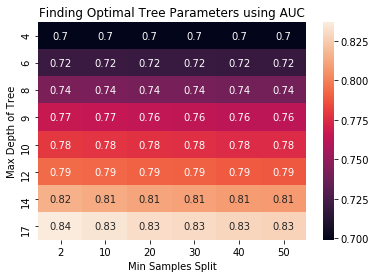

For Cross-validation Data


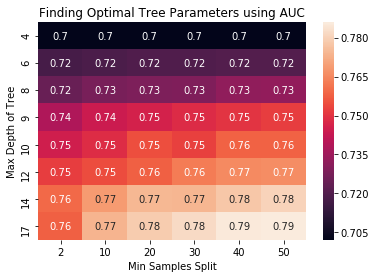

In [445]:
auc_tr,auc_cv=Train_cv(X_tr_BOW,X_cv_BOW,y_tr,y_cv)
print('For Train Data')
plot_heatmap(auc_tr)

print('For Cross-validation Data')
plot_heatmap(auc_cv)

    


In [470]:
m_depth,m_samples_split=14,40

The train-AUC score is 0.8108034266571976
The test-AUC score is 0.7663840624175184


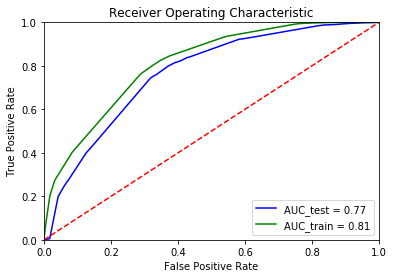

In [489]:
train_pred,test_pred,Dtree_BOW,auc_test=train_test(X_tr_BOW,X_test_BOW,y_tr,y_test,m_depth,m_samples_split)

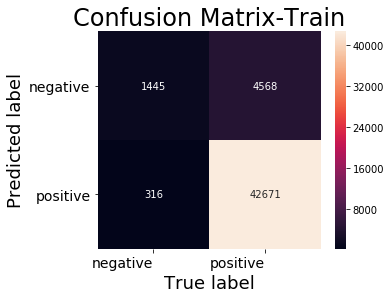

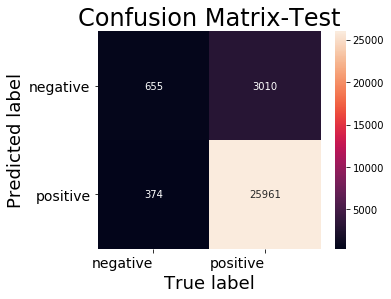

In [474]:
#plotting heatmaps
con_mat(y_tr,train_pred,"Confusion Matrix-Train")
con_mat(y_test,test_pred,"Confusion Matrix-Test")

In [475]:
#to store the final results
from collections import defaultdict
res=defaultdict(list)
res["BOW"]=[m_depth,m_samples_split,auc_test]
res

defaultdict(list, {'BOW': [14, 40, 0.7710638014604045]})

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [490]:
# Please write all the code with proper documentation
imp_feat=Dtree_BOW.feature_importances_
imp_feat
print("Top 20 features")
print(sorted(zip(imp_feat, count_vect.get_feature_names()), reverse=True)[:20])

print("------------------------------------------------------------------------")
print("Bottom 20 features")
print(sorted(zip(imp_feat, count_vect.get_feature_names()), reverse=False)[:20])


Top 20 features
[(0.12478175260657766, 'not'), (0.07962946881422578, 'great'), (0.06351421163719671, 'worst'), (0.05703855771452126, 'best'), (0.054382192306717335, 'money'), (0.05335428522689085, 'disappointed'), (0.042566775017413704, 'horrible'), (0.03276146174037435, 'return'), (0.03075988549125397, 'threw'), (0.030306123607874463, 'delicious'), (0.027132246897031875, 'terrible'), (0.020790366028144606, 'love'), (0.01901986902975123, 'disappointment'), (0.016378547374071302, 'waste'), (0.01363971591843116, 'awful'), (0.013037764723819059, 'good'), (0.012164120960741171, 'disappointing'), (0.010634462679886726, 'worse'), (0.01004458572416103, 'little'), (0.008903579026977118, 'poor')]
------------------------------------------------------------------------
Bottom 20 features
[(0.0, 'aa'), (0.0, 'aaa'), (0.0, 'aaaa'), (0.0, 'aaaaa'), (0.0, 'aaaaaah'), (0.0, 'aaaaah'), (0.0, 'aaaah'), (0.0, 'aaah'), (0.0, 'aaahhhhhh'), (0.0, 'aaahs'), (0.0, 'aachen'), (0.0, 'aadp'), (0.0, 'aaf'), (0.0

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [457]:
# Please write all the code with proper documentation
import graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                              
from ipywidgets import interactive
from sklearn import tree

In [458]:
Dtree=DecisionTreeClassifier(max_depth=3)
Dtree.fit(X_tr_BOW,y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

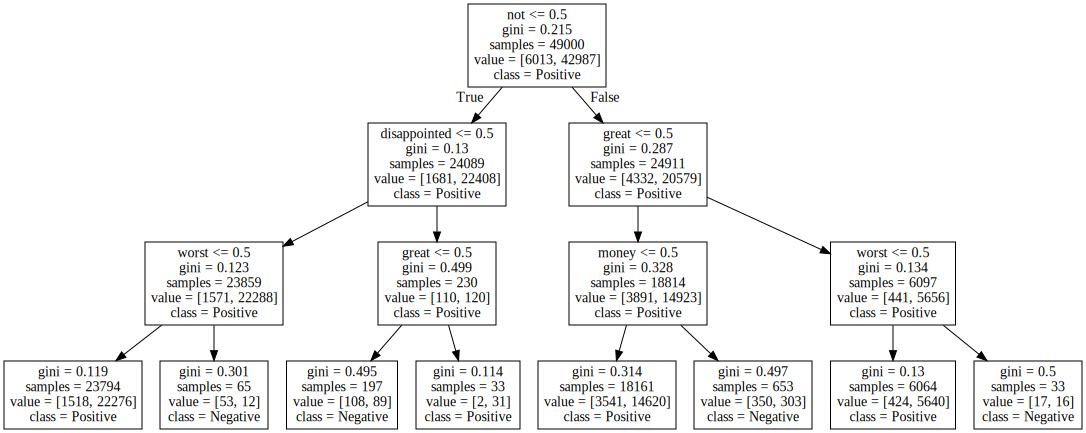

In [459]:
from IPython.display import SVG
graph = Source( tree.export_graphviz(Dtree, out_file=None,feature_names=count_vect.get_feature_names(), class_names=['Negative', 'Positive']))
display(SVG(graph.pipe(format='svg')))

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [517]:
# Please write all the code with proper documentation
with open('X_tr_tfidf.pkl','rb') as f :
    X_tr_tfidf=pickle.load(f)
with open('X_test_tfidf.pkl','rb') as f :
    X_test_tfidf.pkl=pickle.load(f)
with open('X_cv_tfidf.pkl','rb') as f :
    X_cv_tfidf=pickle.load(f)
with open('tf_idf_vect.pkl','rb') as f :
    tf_idf_vect=pickle.load(f)
with open('y_tr.pkl','rb') as f :
    y_tr_=pickle.load(f)
with open('y_test.pkl','rb') as f :
    y_test=pickle.load(f)
with open('y_cv.pkl','rb') as f :
    y_cv=pickle.load(f)




For Train Data


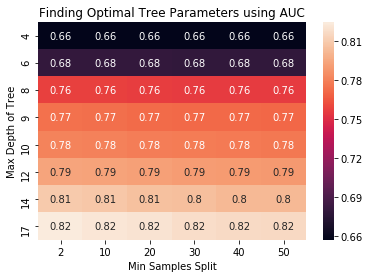

For Cross-validation Data


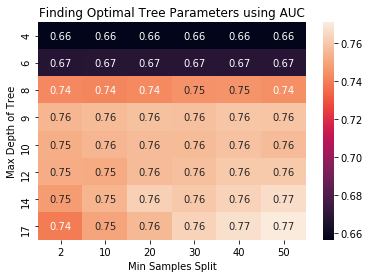

In [518]:
auc_tr,auc_cv=Train_cv(X_tr_tfidf,X_cv_tfidf,y_tr,y_cv)
print('For Train Data')
plot_heatmap(auc_tr)

print('For Cross-validation Data')
plot_heatmap(auc_cv)

    


In [519]:
m_depth,m_samples_split=14,50

The train-AUC score is 0.8018080710209416
The test-AUC score is 0.7658985249090129


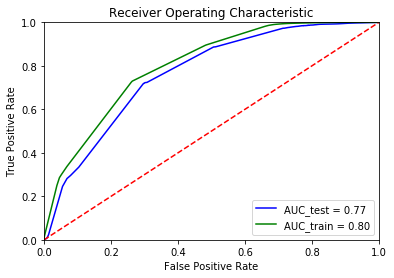

In [520]:
train_pred,test_pred,Dtree_tfidf,auc_test=train_test(X_tr_tfidf,X_test_tfidf,y_tr,y_test,m_depth,m_samples_split)

In [521]:
res["TFIDF"]=[m_depth,m_samples_split,auc_test]
res

defaultdict(list,
            {'BOW': [14, 40, 0.7710638014604045],
             'TFIDF': [14, 50, 0.7658985249090129]})

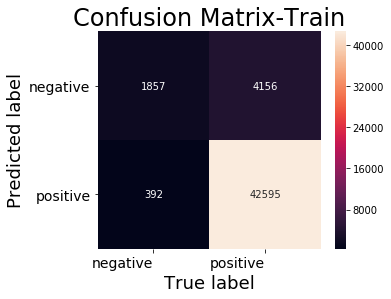

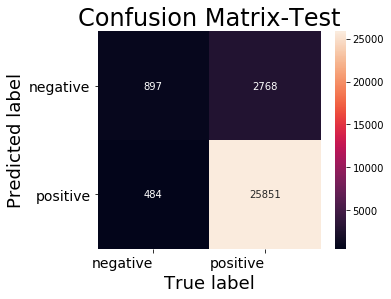

In [522]:
#plotting heatmaps
con_mat(y_tr,train_pred,"Confusion Matrix-Train")
con_mat(y_test,test_pred,"Confusion Matrix-Test")

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [523]:
# Please write all the code with proper documentation
imp_feat=Dtree_tfidf.feature_importances_
imp_feat
print("Top 20 features")
print(sorted(zip(imp_feat, tf_idf_vect.get_feature_names()), reverse=True)[:20])

print("------------------------------------------------------------------------")
print("Bottom 20 features")
print(sorted(zip(imp_feat, tf_idf_vect.get_feature_names()), reverse=False)[:20])


Top 20 features
[(0.15061356043383883, 'not'), (0.07314055014901906, 'great'), (0.061918379362947494, 'worst'), (0.05027015642688209, 'disappointed'), (0.044767487978706104, 'terrible'), (0.04275003597363414, 'not buy'), (0.03927413625586487, 'horrible'), (0.03213771169146361, 'best'), (0.031005082216784392, 'money'), (0.029699791490667267, 'awful'), (0.029256603422891655, 'not worth'), (0.028682937829854958, 'not disappointed'), (0.019714114938970503, 'delicious'), (0.01853295268130876, 'return'), (0.016178572003080715, 'bad'), (0.01578594135067991, 'refund'), (0.01569787306623345, 'not recommend'), (0.013931692902871053, 'disappointment'), (0.013051687356487467, 'waste money'), (0.010504555671632628, 'not purchase')]
------------------------------------------------------------------------
Bottom 20 features
[(0.0, 'abdominal'), (0.0, 'ability'), (0.0, 'able'), (0.0, 'able buy'), (0.0, 'able drink'), (0.0, 'able eat'), (0.0, 'able enjoy'), (0.0, 'able find'), (0.0, 'able get'), (0.0, 

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

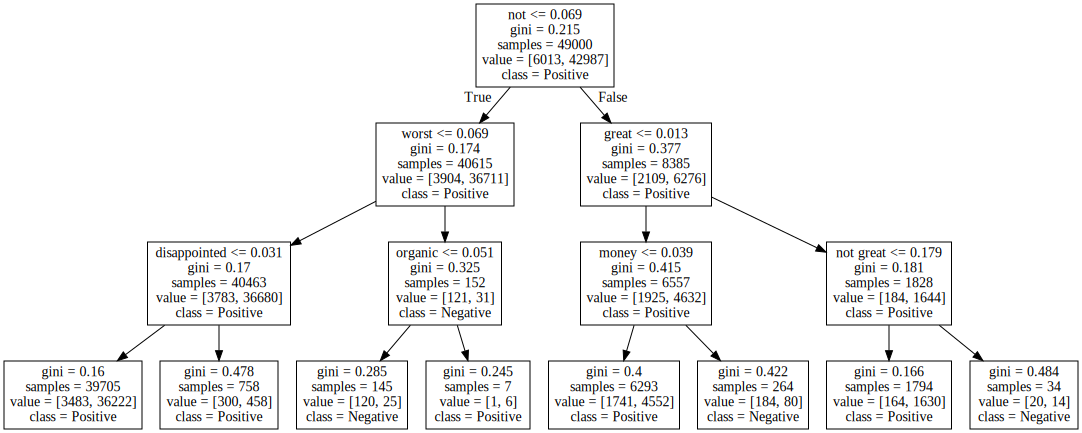

In [525]:
# Please write all the code with proper documentation
Dtree=DecisionTreeClassifier(max_depth=3)
Dtree.fit(X_tr_tfidf,y_tr)
graph = Source( tree.export_graphviz(Dtree, out_file=None,feature_names= tf_idf_vect.get_feature_names(), class_names=['Negative', 'Positive']))
graph


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [531]:
# Please write all the code with proper documentation
with open('X_tr_avgw2v.pkl','rb') as f :
    X_tr_avgw2v=pickle.load(f)
with open('X_test_avgw2v.pkl','rb') as f :
    X_test_avgw2v=pickle.load(f)
with open('X_cv_avgw2v.pkl','rb') as f :
    X_cv_avgw2v=pickle.load(f)

with open('y_tr.pkl','rb') as f :
    y_tr_=pickle.load(f)
with open('y_test.pkl','rb') as f :
    y_test=pickle.load(f)
with open('y_cv.pkl','rb') as f :
    y_cv=pickle.load(f)

For Train Data


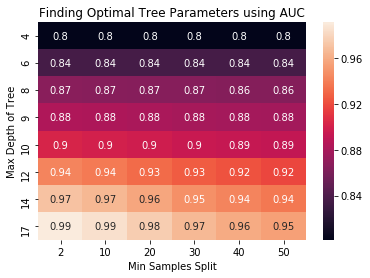

For Cross-validation Data


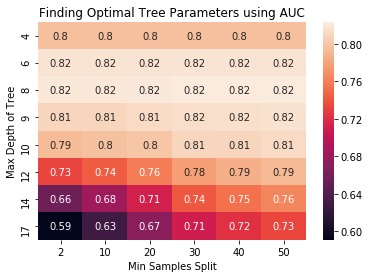

In [532]:
auc_tr,auc_cv=Train_cv(X_tr_avgw2v,X_cv_avgw2v,y_tr,y_cv)
print('For Train Data')
plot_heatmap(auc_tr)

print('For Cross-validation Data')
plot_heatmap(auc_cv)

    


In [540]:
m_depth,m_samples_split=6,30

The train-AUC score is 0.8357963283551962
The test-AUC score is 0.8173604395667016


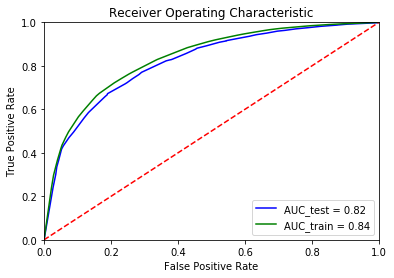

In [541]:
train_pred,test_pred,Dtree_avgw2v,auc_test=train_test(X_tr_avgw2v,X_test_avgw2v,y_tr,y_test,m_depth,m_samples_split)

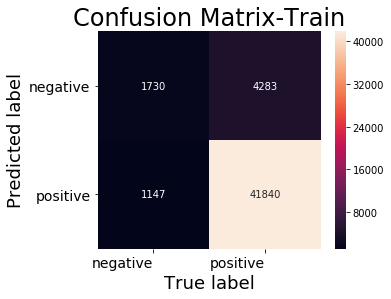

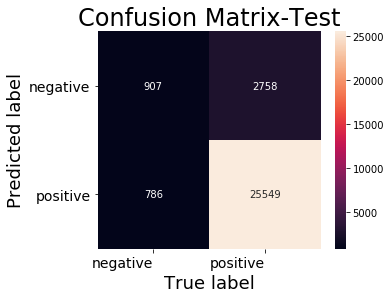

In [543]:
#plotting heatmaps
con_mat(y_tr,train_pred,"Confusion Matrix-Train")
con_mat(y_test,test_pred,"Confusion Matrix-Test")

In [544]:
res["AVG-W2V"]=[m_depth,m_samples_split,auc_test]
res

defaultdict(list,
            {'BOW': [14, 40, 0.7710638014604045],
             'TFIDF': [14, 50, 0.7658985249090129],
             'AVG-W2V': [6, 30, 0.8173604395667016]})

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [555]:
# Please write all the code with proper documentation
with open('X_tr_tfidfw2v','rb') as f :
    X_tr_tfidfw2v=pickle.load(f)
with open('X_test_tfidfw2v','rb') as f :
    X_test_tfidfw2v=pickle.load(f)
with open('X_cv_tfidfw2v','rb') as f :
    X_cv_tfidfw2v=pickle.load(f)

with open('y_tr.pkl','rb') as f :
    y_tr_=pickle.load(f)
with open('y_test.pkl','rb') as f :
    y_test=pickle.load(f)
with open('y_cv.pkl','rb') as f :
    y_cv=pickle.load(f)

For Train Data


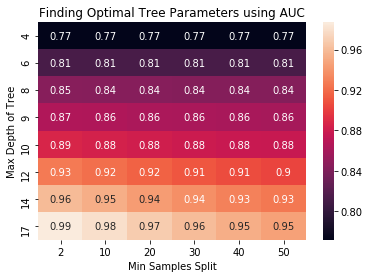

For Cross-validation Data


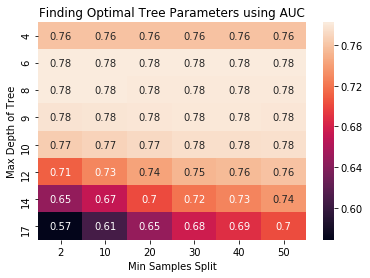

In [556]:
auc_tr,auc_cv=Train_cv(X_tr_tfidfw2v,X_cv_tfidfw2v,y_tr,y_cv)
print('For Train Data')
plot_heatmap(auc_tr)

print('For Cross-validation Data')
plot_heatmap(auc_cv)

    

In [564]:
m_depth,m_samples_split=6,40

The train-AUC score is 0.8124029011652318
The test-AUC score is 0.7812471433370693


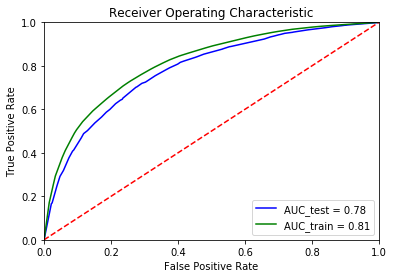

In [565]:
train_pred,test_pred,Dtree_tfidfw2v,auc_test=train_test(X_tr_tfidfw2v,X_test_tfidfw2v,y_tr,y_test,m_depth,m_samples_split)

In [566]:
res["tfidf-W2V"]=[m_depth,m_samples_split,auc_test]
res

defaultdict(list,
            {'BOW': [14, 40, 0.7710638014604045],
             'TFIDF': [14, 50, 0.7658985249090129],
             'AVG-W2V': [6, 30, 0.8173604395667016],
             'tfidf-W2V': [6, 40, 0.7812471433370693]})

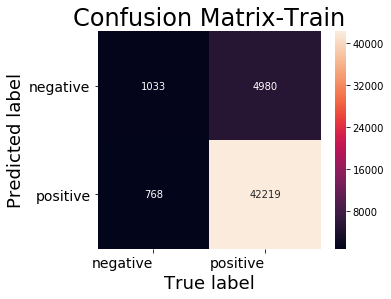

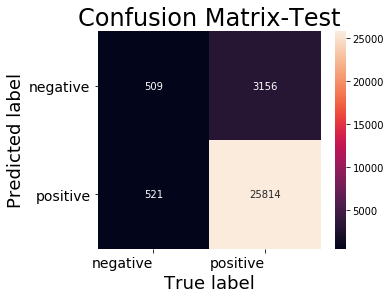

In [567]:
#plotting heatmaps
con_mat(y_tr,train_pred,"Confusion Matrix-Train")
con_mat(y_test,test_pred,"Confusion Matrix-Test")

# [6] Conclusions

In [568]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
name,depth,split,AUC=[],[],[],[]
for i,v in enumerate(res):
    name.append(v)
    depth.append(res[v][0])
    split.append(res[v][1])
    AUC.append(float(res[v][2]*100))
num=[1,2,3,4]
x=PrettyTable()   
x.add_column("S.NO.",num)
x.add_column("MODEL-Name",name)
x.add_column("Optimal Depth",depth)
x.add_column("Minimum_Samples_Split",split)
x.add_column("AUC-Score",AUC)
print(x)


+-------+------------+---------------+-----------------------+-------------------+
| S.NO. | MODEL-Name | Optimal Depth | Minimum_Samples_Split |     AUC-Score     |
+-------+------------+---------------+-----------------------+-------------------+
|   1   |    BOW     |       14      |           40          | 77.10638014604045 |
|   2   |   TFIDF    |       14      |           50          |  76.5898524909013 |
|   3   |  AVG-W2V   |       6       |           30          | 81.73604395667016 |
|   4   | tfidf-W2V  |       6       |           40          | 78.12471433370693 |
+-------+------------+---------------+-----------------------+-------------------+


So we can see that AVG-W2V gives the best AUC-Score

In [8]:
with open('final.pkl','rb') as f :
    final=pickle.load(f)


In [27]:
y=np.array(final["Score"])
len(y)

100000

In [24]:
final=final.iloc[:100000,:]
final["Review_l"]=final["Text"].map(lambda x:len(x))
final["Summary_l"]=final["Summary"].map(lambda x:len(x))

In [74]:
from operator import add 
c1=np.array(final["Review_l"])
c2=np.array(final["Summary_l"])

f = list(map(add, c1, c2)) 


In [75]:
X_1, X_test_l, y_1, y_test_l = train_test_split(f, y, test_size=0.3, random_state=0)
X_tr_l,X_cv_l,y_tr_l,y_cv_l=train_test_split(X_1, y_1, test_size=0.3, random_state=0)

In [76]:
with open('X_tr_avgw2v.pkl','rb') as f :
    X_tr_avgw2v=pickle.load(f)
with open('X_test_avgw2v.pkl','rb') as f :
    X_test_avgw2v=pickle.load(f)
with open('X_cv_avgw2v.pkl','rb') as f :
    X_cv_avgw2v=pickle.load(f)

with open('y_tr.pkl','rb') as f :
    y_tr=pickle.load(f)
with open('y_test.pkl','rb') as f :
    y_test=pickle.load(f)
with open('y_cv.pkl','rb') as f :
    y_cv=pickle.load(f)

In [77]:
X_tr=np.vstack((np.transpose (X_tr_avgw2v),np.transpose(X_tr_l))).T
X_cv=np.vstack((np.transpose (X_cv_avgw2v),np.transpose(X_cv_l))).T
X_test=np.vstack((np.transpose (X_test_avgw2v),np.transpose(X_test_l))).T

For Train Data


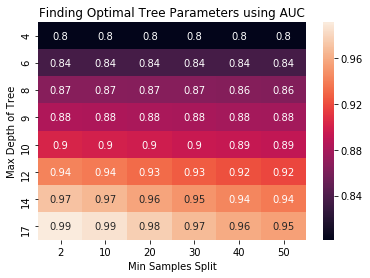

For Cross-validation Data


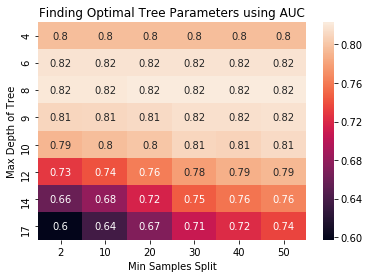

In [78]:
auc_tr,auc_cv=Train_cv(X_tr,X_cv,y_tr,y_cv)
print('For Train Data')
plot_heatmap(auc_tr)

print('For Cross-validation Data')
plot_heatmap(auc_cv)


In [79]:
#now we will test it in with the AVG-W2V
m_depth,m_samples_split=6,40

The train-AUC score is 0.8357963283551962
The test-AUC score is 0.8175675413155763


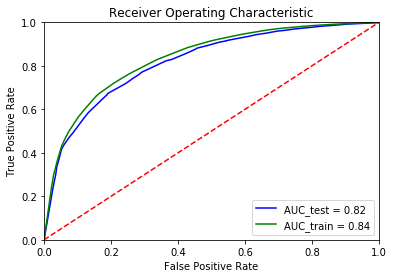

In [80]:
train_pred,test_pred,Dtree,auc_test=train_test(X_tr,X_test,y_tr,y_test,m_depth,m_samples_split)

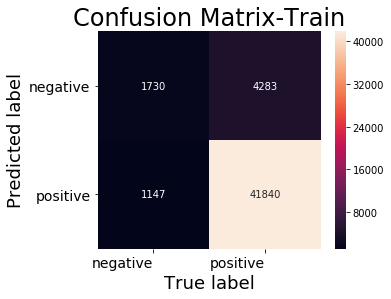

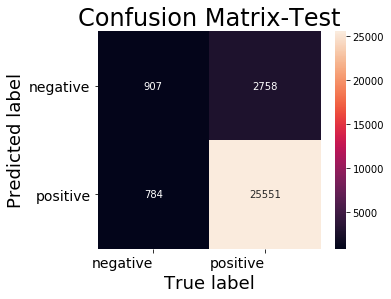

In [46]:
con_mat(y_tr,train_pred,"Confusion Matrix-Train")
con_mat(y_test,test_pred,"Confusion Matrix-Test")